# Semester Project: Translational Neuroengineering Lab

## Import Libraries and Initialize Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mjid import MjID
from tqdm import tqdm
from scipy.interpolate import interp1d
from myoutils import VideoGenerator
from sklearn.decomposition import NMF
from sklearn.metrics import r2_score

# Initialize Myosuite model
my_path = '/Users/Matthieu/Desktop/PROJECT I/FDandID_myosuite'
model_path = os.path.join(my_path, 'code/myo_sim/leg/myolegs_suspended.xml')
mjid = MjID(model_path=model_path, disable_contacts=True)

muscles = np.array(mjid.muscle_names)
joints = np.array(mjid.joint_names)

print('Muscles:', muscles)
print('\nJoints:', joints)

Muscles: ['addbrev_r' 'addlong_r' 'addmagDist_r' 'addmagIsch_r' 'addmagMid_r'
 'addmagProx_r' 'bflh_r' 'bfsh_r' 'edl_r' 'ehl_r' 'fdl_r' 'fhl_r'
 'gaslat_r' 'gasmed_r' 'glmax1_r' 'glmax2_r' 'glmax3_r' 'glmed1_r'
 'glmed2_r' 'glmed3_r' 'glmin1_r' 'glmin2_r' 'glmin3_r' 'grac_r'
 'iliacus_r' 'perbrev_r' 'perlong_r' 'piri_r' 'psoas_r' 'recfem_r'
 'sart_r' 'semimem_r' 'semiten_r' 'soleus_r' 'tfl_r' 'tibant_r'
 'tibpost_r' 'vasint_r' 'vaslat_r' 'vasmed_r' 'addbrev_l' 'addlong_l'
 'addmagDist_l' 'addmagIsch_l' 'addmagMid_l' 'addmagProx_l' 'bflh_l'
 'bfsh_l' 'edl_l' 'ehl_l' 'fdl_l' 'fhl_l' 'gaslat_l' 'gasmed_l' 'glmax1_l'
 'glmax2_l' 'glmax3_l' 'glmed1_l' 'glmed2_l' 'glmed3_l' 'glmin1_l'
 'glmin2_l' 'glmin3_l' 'grac_l' 'iliacus_l' 'perbrev_l' 'perlong_l'
 'piri_l' 'psoas_l' 'recfem_l' 'sart_l' 'semimem_l' 'semiten_l' 'soleus_l'
 'tfl_l' 'tibant_l' 'tibpost_l' 'vasint_l' 'vaslat_l' 'vasmed_l']

Joints: ['hip_flexion_r' 'hip_adduction_r' 'hip_rotation_r'
 'knee_angle_r_translation2' 'knee_angle_r

## Define Excitation Curves and Activation Dynamics

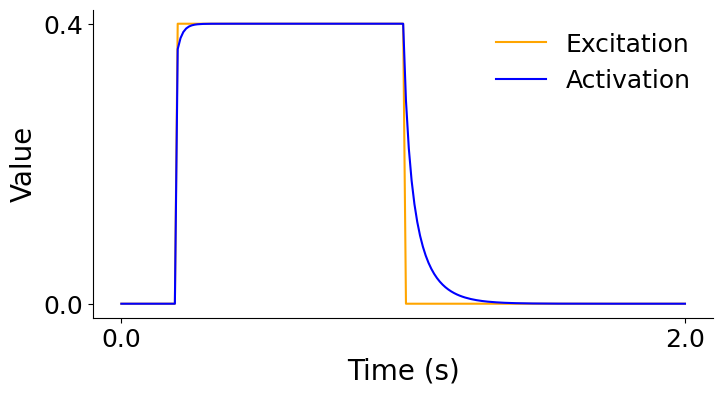

In [2]:
# Time and excitation curves
time = np.linspace(0, 2, num=201)
no_excitation_curve = np.zeros_like(time)
excitation_curve = np.where((time >= 0.2) & (time <= 1.0), 0.4, 0.0)

# Activation dynamics parameters
tau_activation = 0.022
tau_deactivation = 0.040
min_activation = 0.00

# Compute rate of change of activation
def compute_dadt(u, a, tau_activation, tau_deactivation):
    tau = tau_activation * (0.5 + 1.5 * a) if u > a else tau_deactivation / (0.5 + 1.5 * a)
    return (u - a) / tau

# Simulate activation over time
activation = np.zeros_like(time)
activation[0] = min_activation
for i in range(1, len(time)):
    dt = time[i] - time[i-1]
    dadt = compute_dadt(excitation_curve[i], activation[i-1], tau_activation, tau_deactivation)
    activation[i] = max(activation[i-1] + dadt * dt, min_activation)

# Plot excitation and activation
plt.figure(figsize=(8, 4))
plt.plot(time, excitation_curve, label='Excitation', color='orange')
plt.plot(time, activation, label='Activation', color='blue')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.legend(frameon=False, fontsize=18)

# Remove the top and right sides of the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep only the first and last ticks for x and y axes
plt.xticks([time[0], time[-1]], [f"{time[0]:.1f}", f"{time[-1]:.1f}"], fontsize=18)
plt.yticks([0.0, 0.4], ["0.0", "0.4"], fontsize=18)

plt.show()

## Joint Movements

### Define Muscle Groups and Simulation Function

In [3]:
# Muscle groups for each movement
hip_flexion_r = ["iliacus_r", "psoas_r", "recfem_r"]
hip_adduction_r = ["addlong_r", "addbrev_r", "grac_r"]
knee_flexion_r = ["bflh_r", "semiten_r", "semimem_r"]
ankle_dorsiflexion_r = ["tibant_r", "ehl_r", "edl_r"]

# Simulate muscle activation and joint movement
def simulate_muscle_activation(mjid, joint_name, muscle_name, excitation_curve, time_step=0.001, t_end=2.0):
    mjid.reset_data()
    joint_idx = mjid.joint_names.index(joint_name)
    muscle_idx = mjid.muscle_names.index(muscle_name)

    time_values, joint_angle_values, muscle_activations = [], [], []
    activation = min_activation

    t = 0.0
    while t <= t_end:
        time_values.append(t)
        joint_angle_values.append(mjid.data.qpos[joint_idx])
        muscle_activations.append(mjid.data.act[muscle_idx])

        excitation = np.interp(t, time, excitation_curve)
        dadt = compute_dadt(excitation, activation, tau_activation, tau_deactivation)
        activation = max(activation + dadt * time_step, min_activation)
        mjid.data.act[muscle_idx] = activation

        mjid.step_forward(mjid.data.ctrl)
        t += time_step

    return time_values, joint_angle_values, muscle_activations

In [4]:
# Excitation for each muscle in hip flexion
time_values, hip_f_values_no_exc, _ = simulate_muscle_activation(mjid, "hip_flexion_r", "iliacus_r", no_excitation_curve)
_, hip_f_values_exc1, _ = simulate_muscle_activation(mjid, "hip_flexion_r", "iliacus_r", excitation_curve)
_, hip_f_values_exc2, _ = simulate_muscle_activation(mjid, "hip_flexion_r", "psoas_r", excitation_curve)
_, hip_f_values_exc3, _ = simulate_muscle_activation(mjid, "hip_flexion_r", "recfem_r", excitation_curve)

# Simulate with excitation for all muscles
_, hip_a_values_no_exc, _ = simulate_muscle_activation(mjid, "hip_adduction_r", "addlong_r", no_excitation_curve)
_, hip_a_values_exc1, _ = simulate_muscle_activation(mjid, "hip_adduction_r", "addlong_r", excitation_curve)
_, hip_a_values_exc2, _ = simulate_muscle_activation(mjid, "hip_adduction_r", "addbrev_r", excitation_curve)
_, hip_a_values_exc3, _ = simulate_muscle_activation(mjid, "hip_adduction_r", "grac_r", excitation_curve)

# Excitation for each muscle in knee flexion
_, knee_f_values_no_exc, _ = simulate_muscle_activation(mjid, "knee_angle_r", "bflh_r", no_excitation_curve)
_, knee_f_values_exc1, _ = simulate_muscle_activation(mjid, "knee_angle_r", "bflh_r", excitation_curve)
_, knee_f_values_exc2, _ = simulate_muscle_activation(mjid, "knee_angle_r", "semiten_r", excitation_curve)
_, knee_f_values_exc3, _ = simulate_muscle_activation(mjid, "knee_angle_r", "semimem_r", excitation_curve)

# Excitation for each muscle in ankle dorsiflexion
_, ankle_d_values_no_exc, _ = simulate_muscle_activation(mjid, "ankle_angle_r", "tibant_r", no_excitation_curve)
_, ankle_d_values_exc1, _ = simulate_muscle_activation(mjid, "ankle_angle_r", "tibant_r", excitation_curve)
_, ankle_d_values_exc2, _ = simulate_muscle_activation(mjid, "ankle_angle_r", "ehl_r", excitation_curve)
_, ankle_d_values_exc3, _ = simulate_muscle_activation(mjid, "ankle_angle_r", "edl_r", excitation_curve)

### Simulate and Plot Results

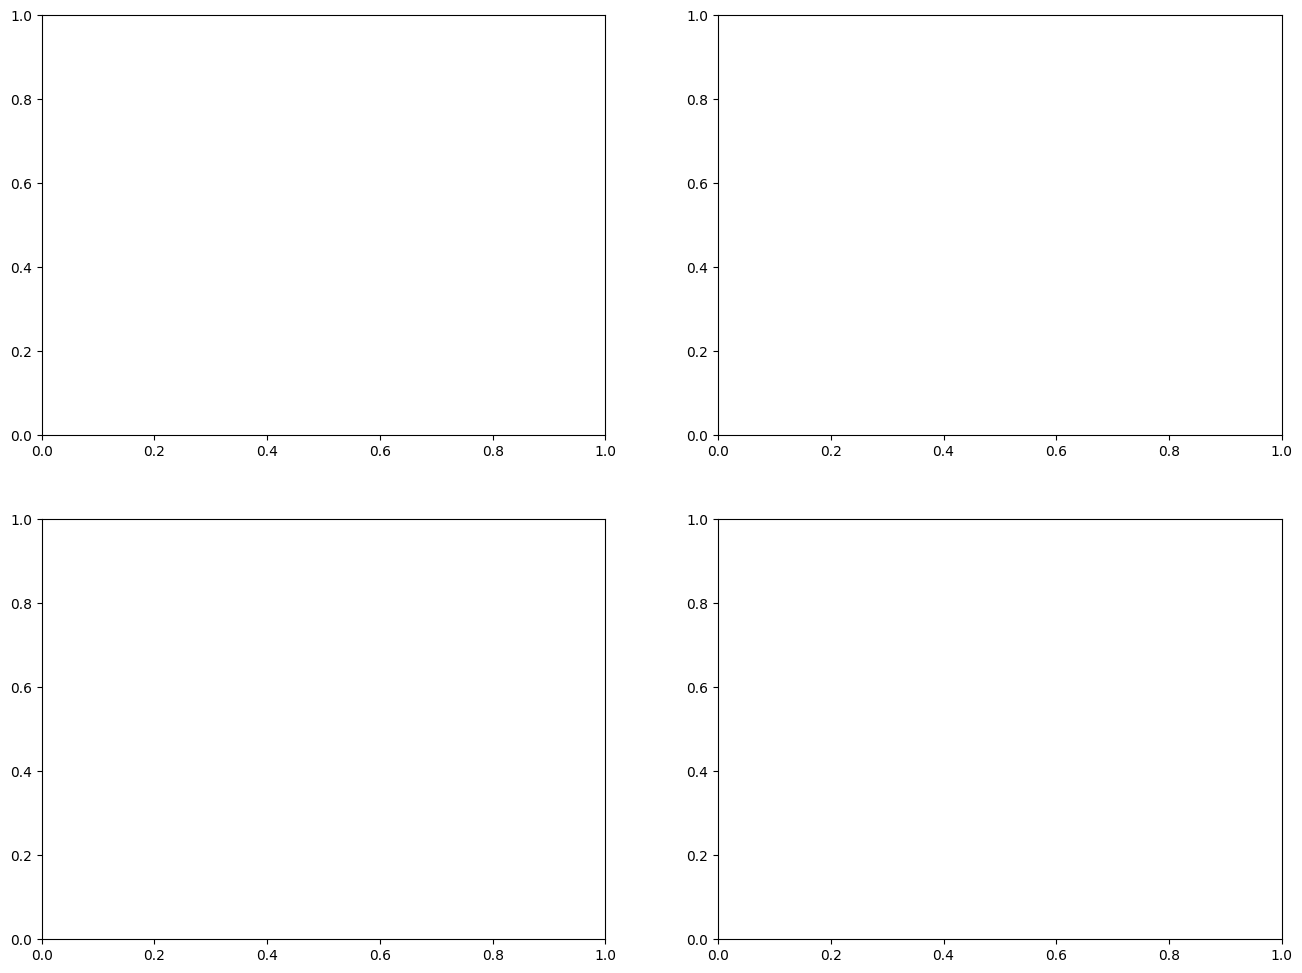

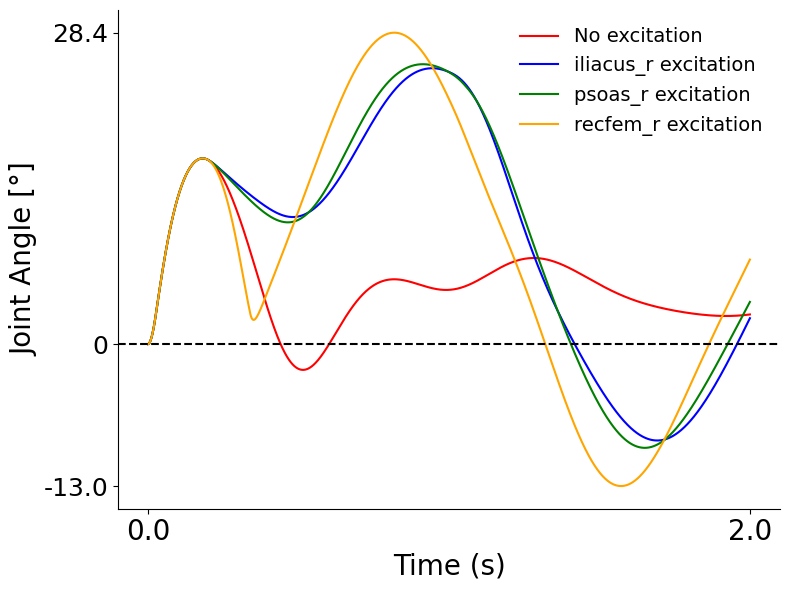

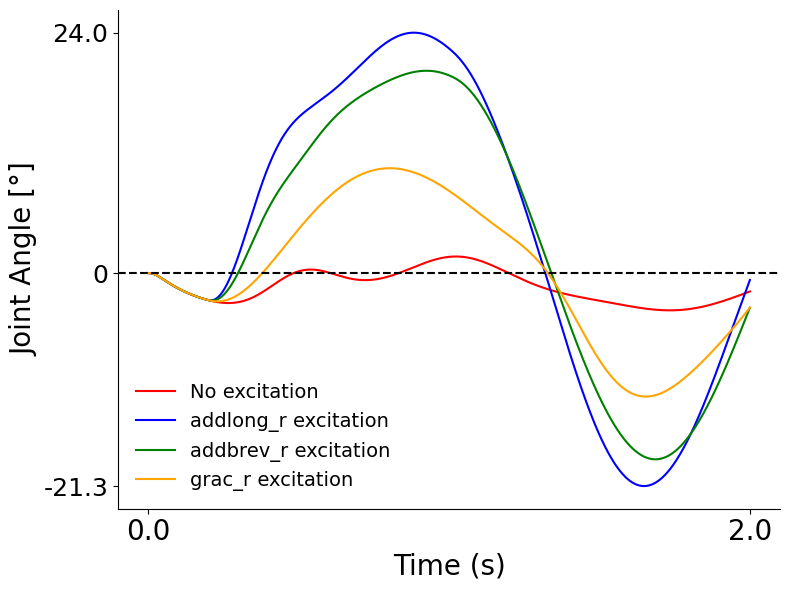

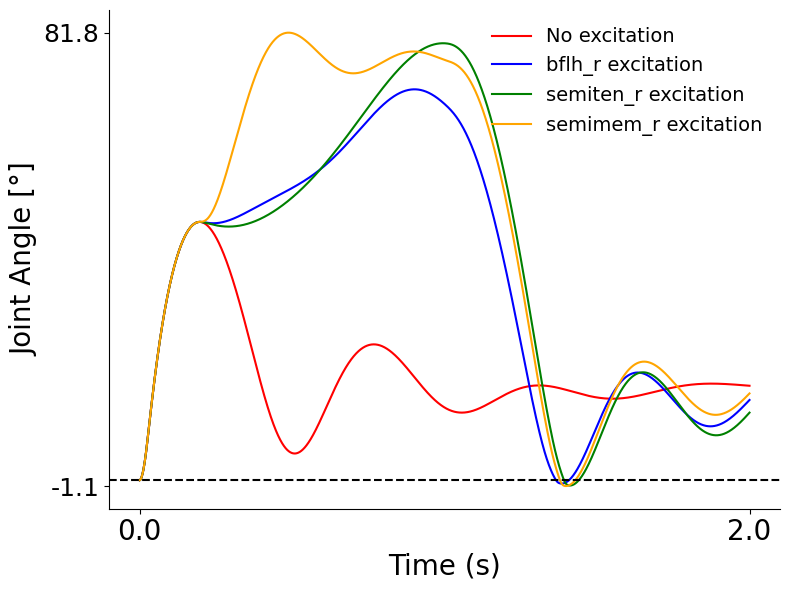

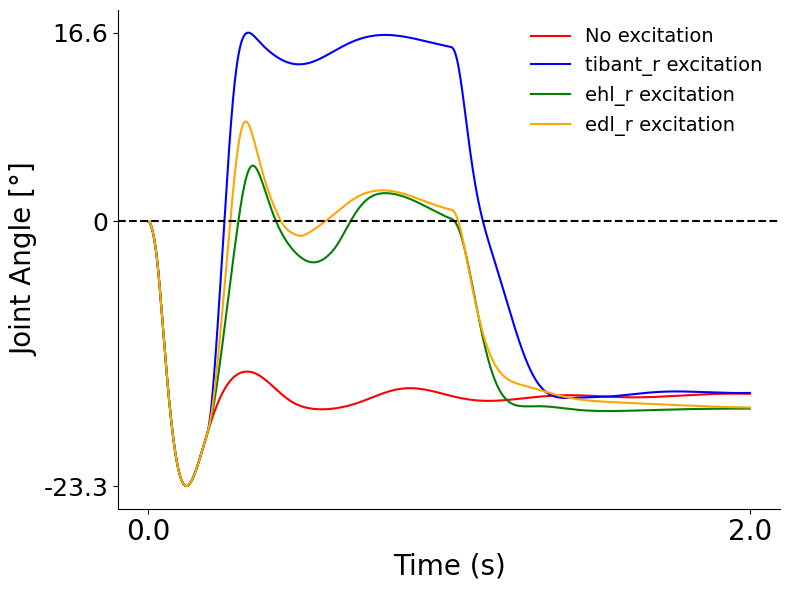

In [5]:
# Simulate joint movements for each condition
def simulate_joint_movements(joint_name, muscles, excitation_curve, time_step=0.001, t_end=2.0):
    results = []
    for muscle in muscles:
        time_values, joint_values, _ = simulate_muscle_activation(
            mjid, joint_name, muscle, excitation_curve, time_step, t_end)
        results.append(joint_values)
    return time_values, results

# Simulate for all movements
time_values, hip_f_no_exc, _ = simulate_muscle_activation(mjid, "hip_flexion_r", hip_flexion_r[0], no_excitation_curve)
_, hip_a_no_exc, _ = simulate_muscle_activation(mjid, "hip_adduction_r", hip_adduction_r[0], no_excitation_curve)
_, knee_f_no_exc, _ = simulate_muscle_activation(mjid, "knee_angle_r", knee_flexion_r[0], no_excitation_curve)
_, ankle_d_no_exc, _ = simulate_muscle_activation(mjid, "ankle_angle_r", ankle_dorsiflexion_r[0], no_excitation_curve)

# Simulate with excitation for all muscles
_, hip_f_values_exc = simulate_joint_movements("hip_flexion_r", hip_flexion_r, excitation_curve)
_, hip_a_values_exc = simulate_joint_movements("hip_adduction_r", hip_adduction_r, excitation_curve)
_, knee_f_values_exc = simulate_joint_movements("knee_angle_r", knee_flexion_r, excitation_curve)
_, ankle_d_values_exc = simulate_joint_movements("ankle_angle_r", ankle_dorsiflexion_r, excitation_curve)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Movements data
# Movements data
movements = [
    ("Hip Flexion", hip_flexion_r, hip_f_no_exc, hip_f_values_exc),
    ("Hip Adduction", hip_adduction_r, hip_a_values_no_exc, hip_a_values_exc),
    ("Knee Flexion", knee_flexion_r, knee_f_values_no_exc, knee_f_values_exc),
    ("Ankle Dorsiflexion", ankle_dorsiflexion_r, ankle_d_values_no_exc, ankle_d_values_exc),
]

# Create individual plots for each movement
for idx, (title, muscles, no_exc_values, exc_values) in enumerate(movements):
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot

    # Plot "No excitation" curve
    plt.plot(time_values, np.degrees(no_exc_values), label="No excitation", color='red')

    # Plot excitation curves for each muscle
    for i, muscle in enumerate(muscles):
        plt.plot(time_values, np.degrees(exc_values[i]), label=f"{muscle} excitation", color=['blue', 'green', 'orange'][i])

    # Add a dashed horizontal line at y=0
    plt.axhline(y=0, color='black', linewidth=1.5, linestyle="--")

    # Calculate the min and max values across all curves
    all_values = [np.degrees(no_exc_values)] + [np.degrees(exc) for exc in exc_values]
    y_min = np.min([np.min(values) for values in all_values])
    y_max = np.max([np.max(values) for values in all_values])

    # Set title and labels
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Joint Angle [°]", fontsize=20)

    # Customize ticks: Only first, last, and 0 for y-axis
    if idx == 2:  # For the 3rd plot (index 2), remove the 0 tick
        plt.yticks([y_min, y_max], [f"{y_min:.1f}", f"{y_max:.1f}"], fontsize=18)
    else:
        plt.yticks([0, y_min, y_max], [f"0", f"{y_min:.1f}", f"{y_max:.1f}"], fontsize=18)

    # Customize ticks: Only first and last values for x-axis
    plt.xticks([time_values[0], time_values[-1]], [f"{time_values[0]:.1f}", f"{time_values[-1]:.1f}"], fontsize=20)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove the grid
    # (No plt.grid() call)

    # Add legend with larger font size and no box
    plt.legend(frameon=False, fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Muscle Parameter Change

### Functions for Retrieving and Modifying Muscle Parameters

In [6]:
def print_muscle_parameters_mujoco(mjid, muscle_name):
    muscle_idx = mjid.muscle_names.index(muscle_name)
    max_isometric_force = mjid.model.actuator_gainprm[muscle_idx][2]
    optimal_fiber_length = mjid.model.actuator_biasprm[muscle_idx][0]
    tendon_slack_length = mjid.model.actuator_biasprm[muscle_idx][1]

    print(f"- {muscle_name}: {max_isometric_force} N, {optimal_fiber_length} m, {tendon_slack_length} m")


def print_all_muscle_parameters_mujoco(mjid, muscle_names):
    for muscle_name in muscle_names:
        print_muscle_parameters_mujoco(mjid, muscle_name)


def get_muscle_parameters(mjid, muscle_name):
    muscle_idx = mjid.muscle_names.index(muscle_name)
    return {
        "max_isometric_force": mjid.model.actuator_gainprm[muscle_idx][2],
        "optimal_fiber_length": mjid.model.actuator_biasprm[muscle_idx][0],
        "tendon_slack_length": mjid.model.actuator_biasprm[muscle_idx][1],
    }


def set_muscle_parameters(mjid, muscle_name, params):
    muscle_idx = mjid.muscle_names.index(muscle_name)
    if "max_isometric_force" in params:
        mjid.model.actuator_gainprm[muscle_idx][2] = params["max_isometric_force"]
    if "optimal_fiber_length" in params:
        mjid.model.actuator_biasprm[muscle_idx][0] = params["optimal_fiber_length"]
    if "tendon_slack_length" in params:
        mjid.model.actuator_biasprm[muscle_idx][1] = params["tendon_slack_length"]


def modify_muscle_parameters(mjid, muscle_name, **kwargs):
    original_params = get_muscle_parameters(mjid, muscle_name)
    set_muscle_parameters(mjid, muscle_name, {**original_params, **kwargs})
    return original_params

### Function to Process Muscle Activation

In [7]:
def process_muscle_activation(
    mjid, joint_name, muscle_name, no_excitation_curve, excitation_curve, 
    scale_factor=0.5, parameter="max_isometric_force"):

    # Retrieve original muscle parameters
    original_params = get_muscle_parameters(mjid, muscle_name)
    print(f"\nOriginal parameters for {muscle_name}: {original_params}")

    # Validate the parameter to modify
    if parameter not in original_params:
        raise ValueError(
            f"Invalid parameter '{parameter}'. Choose from 'max_isometric_force', 'optimal_fiber_length', or 'tendon_slack_length'."
        )

    # Simulate before parameter modification
    time_values, values_no_exc, _ = simulate_muscle_activation(mjid, joint_name, muscle_name, no_excitation_curve)
    _, values_exc_before, _ = simulate_muscle_activation(mjid, joint_name, muscle_name, excitation_curve)

    # Modify and print the specified muscle parameter
    new_value = scale_factor * original_params[parameter]
    modify_muscle_parameters(mjid, muscle_name, **{parameter: new_value})

    updated_params = get_muscle_parameters(mjid, muscle_name)
    print(f"Updated parameters for {muscle_name}: {updated_params}")

    # Simulate before parameter modification
    _, values_exc_after, _ = simulate_muscle_activation( mjid, joint_name, muscle_name, excitation_curve)

    return time_values, values_no_exc, values_exc_before, values_exc_after

### Simulate and Visualize Results


Original parameters for psoas_r: {'max_isometric_force': 1385.41, 'optimal_fiber_length': 0.497633, 'tendon_slack_length': 1.12953}


Updated parameters for psoas_r: {'max_isometric_force': 415.623, 'optimal_fiber_length': 0.497633, 'tendon_slack_length': 1.12953}

Original parameters for semimem_r: {'max_isometric_force': 2249.55, 'optimal_fiber_length': 0.1, 'tendon_slack_length': 1.8}
Updated parameters for semimem_r: {'max_isometric_force': 674.865, 'optimal_fiber_length': 0.1, 'tendon_slack_length': 1.8}

Original parameters for tibant_r: {'max_isometric_force': 1152.86, 'optimal_fiber_length': 0.601012, 'tendon_slack_length': 1.38869}
Updated parameters for tibant_r: {'max_isometric_force': 345.85799999999995, 'optimal_fiber_length': 0.601012, 'tendon_slack_length': 1.38869}

Plot saved to outputs/joint_kinematics_with_excitation.png


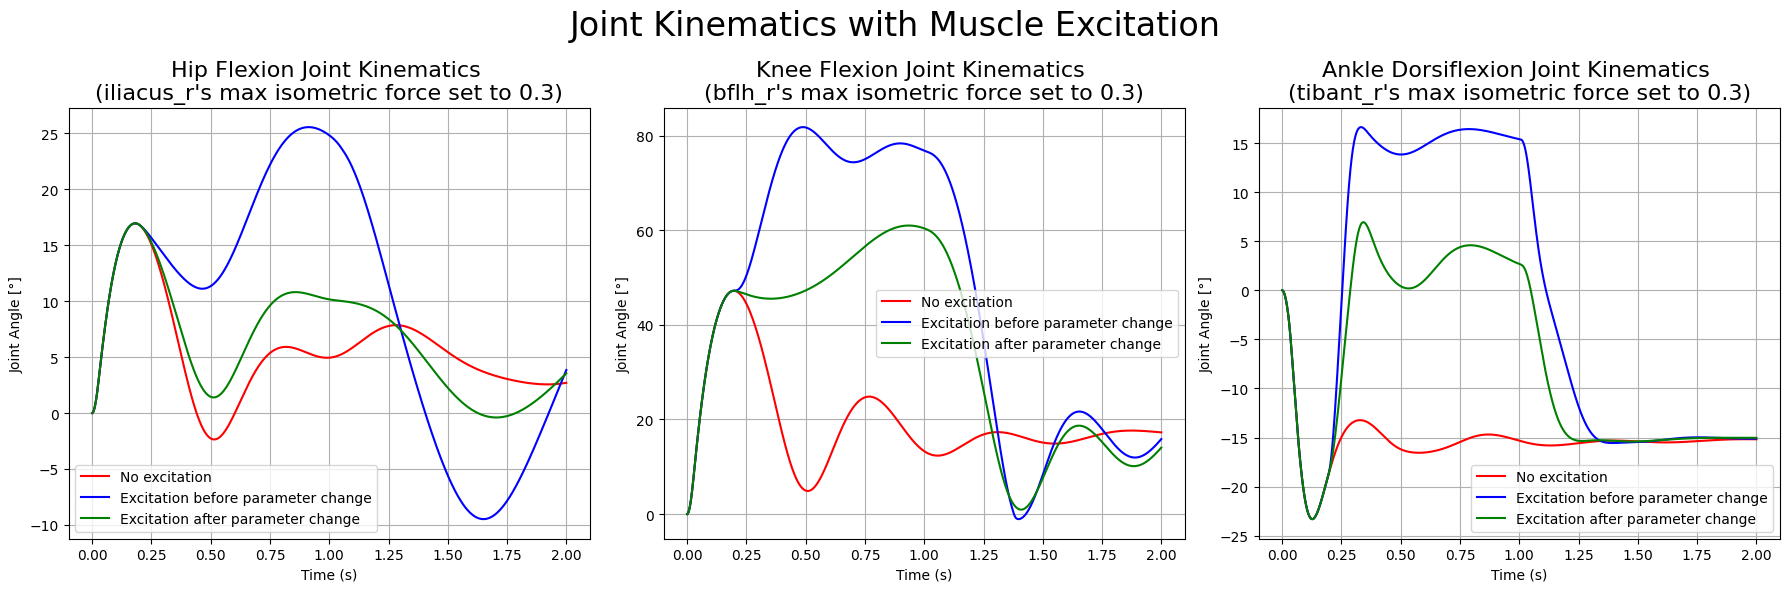

In [8]:
# Simulate muscle parameter change
original_hip_params = get_muscle_parameters(mjid, hip_flexion_r[1])
time_values, hip_f_values_no_exc, hip_f_values_exc_before, hip_f_values_exc_after = process_muscle_activation(
    mjid, "hip_flexion_r", hip_flexion_r[1], no_excitation_curve, excitation_curve, scale_factor=0.3, parameter="max_isometric_force")
set_muscle_parameters(mjid, hip_flexion_r[1], original_hip_params)

original_knee_params = get_muscle_parameters(mjid, knee_flexion_r[2])
_, knee_f_values_no_exc, knee_f_values_exc_before, knee_f_values_exc_after = process_muscle_activation(
    mjid, "knee_angle_r", knee_flexion_r[2], no_excitation_curve, excitation_curve, scale_factor=0.3, parameter="max_isometric_force")
set_muscle_parameters(mjid, knee_flexion_r[2], original_knee_params)

original_ankle_params = get_muscle_parameters(mjid, ankle_dorsiflexion_r[0])
_, ankle_d_values_no_exc, ankle_d_values_exc_before, ankle_d_values_exc_after = process_muscle_activation(
    mjid, "ankle_angle_r", ankle_dorsiflexion_r[0], no_excitation_curve, excitation_curve, scale_factor=0.3, parameter="max_isometric_force")
set_muscle_parameters(mjid, ankle_dorsiflexion_r[0], original_ankle_params)

# Create output folder
output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)

# Plot results
plt.figure(figsize=(18, 6))
plt.suptitle("Joint Kinematics with Muscle Excitation", fontsize=24)

# Hip Flexion Plot
plt.subplot(1, 3, 1)
plt.plot(time_values, np.degrees(hip_f_values_no_exc), label='No excitation', color='red')
plt.plot(time_values, np.degrees(hip_f_values_exc_before), label='Excitation before parameter change', color='blue')
plt.plot(time_values, np.degrees(hip_f_values_exc_after), label='Excitation after parameter change', color='green')
plt.title(f"Hip Flexion Joint Kinematics \n({hip_flexion_r[0]}'s max isometric force set to 0.3)", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle [°]")
plt.legend()
plt.grid()

# Knee Flexion Plot
plt.subplot(1, 3, 2)
plt.plot(time_values, np.degrees(knee_f_values_no_exc), label='No excitation', color='red')
plt.plot(time_values, np.degrees(knee_f_values_exc_before), label='Excitation before parameter change', color='blue')
plt.plot(time_values, np.degrees(knee_f_values_exc_after), label='Excitation after parameter change', color='green')
plt.title(f"Knee Flexion Joint Kinematics \n({knee_flexion_r[0]}'s max isometric force set to 0.3)", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle [°]")
plt.legend()
plt.grid()

# Ankle Dorsiflexion Plot
plt.subplot(1, 3, 3)
plt.plot(time_values, np.degrees(ankle_d_values_no_exc), label='No excitation', color='red')
plt.plot(time_values, np.degrees(ankle_d_values_exc_before), label='Excitation before parameter change', color='blue')
plt.plot(time_values, np.degrees(ankle_d_values_exc_after), label='Excitation after parameter change', color='green')
plt.title(f"Ankle Dorsiflexion Joint Kinematics \n({ankle_dorsiflexion_r[0]}'s max isometric force set to 0.3)", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle [°]")
plt.legend()
plt.grid()

plt.tight_layout()

# Save the plot
filename = os.path.join(output_folder, "joint_kinematics_with_excitation.png")
plt.savefig(filename)
print(f"\nPlot saved to {filename}")

plt.show()
plt.close()

## Kinematic Comparison and Muscle Activation

### Forward and Inverse Dynamics Functions

In [9]:
def interpolate_trajectory(traj, time_original, time_step_new):
    time_new = np.arange(0, time_original[-1] + time_step_new, time_step_new)
    interp_func = interp1d(time_original, traj, axis=0, kind='cubic', fill_value="extrapolate")
    traj_interpolated = interp_func(time_new)
    return traj_interpolated, time_new


def moving_average(data, duration, fs):
    window_size = int(duration * fs)
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')


def forward_dynamics(activations, my_path, initial_qpos=None, initial_qvel=None, gen_video=True):
    T = activations.shape[0]
    initial_qpos = initial_qpos if initial_qpos is not None else mjid.data.qpos.copy()
    initial_qvel = initial_qvel if initial_qvel is not None else mjid.data.qvel.copy()

    mjid.reset_data(initial_qpos)
    mjid.data.qvel[:] = initial_qvel.copy()

    all_qpos, all_qvel = np.zeros((T, mjid.model.nq)), np.zeros((T, mjid.model.nv))
    all_ctrl, all_act = np.zeros((T, mjid.model.nu)), np.zeros((T, mjid.model.nu))

    if gen_video:
        vg = VideoGenerator(mjid.model, mjid.data, os.path.join(my_path, 'results/FD'))

    for idx in tqdm(range(T)):
        ctrl = activations[idx, :]
        mjid.data.ctrl[:] = ctrl
        mjid.step_forward(ctrl)

        all_qpos[idx], all_qvel[idx] = mjid.data.qpos.copy(), mjid.data.qvel.copy()
        all_ctrl[idx], all_act[idx] = ctrl, mjid.data.act.copy()

        if gen_video:
            vg.step(mjid.data.qpos, idx)

    if gen_video:
        vg.release()

    return all_qpos, all_qvel, all_ctrl, all_act


def inverse_dynamics(traj, qidxs_of_interest, fs, task, movement, side='', gen_video=True):
    # Generate time vector for the original trajectory
    time_motion = np.linspace(0, traj.shape[0] / fs, traj.shape[0])
    traj_interpolated, time_msk = interpolate_trajectory(traj, time_motion, mjid.model.opt.timestep)

    # Initialize joint data
    all_joints = np.zeros((traj_interpolated.shape[0], len(mjid.joint_names)))
    all_joints[:, qidxs_of_interest] = np.deg2rad(traj_interpolated)

    # Add padding for stabilization
    padding_samples = 500
    all_joints_pad = np.vstack((np.tile(all_joints[0], (padding_samples, 1)), all_joints))

    # Set PD gains and regularization parameters
    kp, kv, re, rs, rd, rr = 1500, 300, 80, 200, 0, 80
    kp2set, kv2set = kp * np.ones(mjid.model.nq), kv * np.ones(mjid.model.nq)
    rr2set = np.ones(mjid.model.nv)

    if side == 'l':
        kp2set[[14, 19, 22]], rr2set[[14, 19, 22]] = 10000, 1000
    elif side == 'r':
        kp2set[[0, 5, 8]], rr2set[[0, 5, 8]] = 10000, 1000

    mjid.update_gains(kp=kp2set, kv=kv2set)
    mjid.update_regs(rr=rr2set, re=re * np.ones(mjid.model.nu), rs=rs, rd=rd)
    mjid.reset_data(all_joints_pad[0])

    # Initialize arrays for results
    T = all_joints_pad.shape[0]
    all_ctrl_achiev = np.zeros((T, mjid.model.nu))
    all_data_act = np.zeros((T, mjid.model.nu))
    all_qpos_achiev = np.zeros((T, mjid.model.nq))

    # Prepare for video generation
    if gen_video:
        save_path = '/Users/Matthieu/Desktop/PROJECT I/FDandID_myosuite/results'
        video_name = f"{movement}_{task}.mp4"
        video_path = os.path.join(save_path, video_name)

        # Remove existing video file if it exists
        if os.path.exists(video_path):
            os.remove(video_path)

        vg = VideoGenerator(mjid.model, mjid.data, video_path)

    # Simulation loop
    for idx in tqdm(range(T)):
        qpos_target = all_joints_pad[idx]
        actuation, _ = mjid.get_ctrl(qpos_target)
        all_ctrl_achiev[idx] = actuation
        all_data_act[idx] = mjid.data.act
        all_qpos_achiev[idx], _ = mjid.step_forward(actuation)

        # Generate video frames
        if gen_video and idx >= padding_samples:
            vg.step(qpos_target, idx)

    # Finalize video generation
    if gen_video:
        vg.release()

    # Smooth muscle activations
    msk_data = np.array([moving_average(all_data_act[:, i], 0.5, 1 / mjid.model.opt.timestep) for i in range(all_data_act.shape[1])]).T

    return msk_data[padding_samples:], time_msk, all_qpos_achiev[padding_samples:]

### Kinematic Comparison and Muscle Activations

In [10]:
# Define the kinematics for all tasks
kinematics_tasks = {
    "excitation before parameter change": {
        "hip": hip_f_values_exc_before,
        "knee": knee_f_values_exc_before,
        "ankle": ankle_d_values_exc_before
    },
    "excitation after parameter change": {
        "hip": hip_f_values_exc_after,
        "knee": knee_f_values_exc_after,
        "ankle": ankle_d_values_exc_after
    }
}

# Define movement and their corresponding kinematics keys
joint_mappings = {
    "hip": "Hip Flexion",
    "knee": "Knee Flexion",
    "ankle": "Ankle Dorsiflexion"
}


def interpolate(data, target_length):
    original_length = len(data)
    original_time = np.linspace(0, 1, original_length)
    target_time = np.linspace(0, 1, target_length)
    return np.interp(target_time, original_time, data)


def plot_kinematic_comparison(time, qpos_id_before, qpos_fd_before, qpos_id_after, qpos_fd_after, movement, qidxs_of_interest, title_suffix="", output_folder="outputs"):
    joint_idx = qidxs_of_interest[list(joint_mappings.keys()).index(movement)]

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    plt.figure(figsize=(10, 6))

    plt.plot(time, np.degrees(qpos_id_before[:, joint_idx]), label='Target (Before)', linestyle='--', linewidth=3, color='blue')
    plt.plot(time, np.degrees(qpos_fd_before[:, joint_idx]), label='Achieved (Before)', linewidth=3, color='#0099ff')
    plt.plot(time, np.degrees(qpos_id_after[:, joint_idx]), label='Target (After)', linestyle='--', linewidth=3, color='red')
    plt.plot(time, np.degrees(qpos_fd_after[:, joint_idx]), label='Achieved (After)', linewidth=3, color='orange')

    # Add a dashed horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Customize ticks: Only first and last values for x and y axes
    y_min = np.min([np.degrees(qpos_id_before[:, joint_idx]), np.degrees(qpos_fd_before[:, joint_idx]),
                    np.degrees(qpos_id_after[:, joint_idx]), np.degrees(qpos_fd_after[:, joint_idx])])
    y_max = np.max([np.degrees(qpos_id_before[:, joint_idx]), np.degrees(qpos_fd_before[:, joint_idx]),
                    np.degrees(qpos_id_after[:, joint_idx]), np.degrees(qpos_fd_after[:, joint_idx])])
    plt.xticks([time[0], time[-1]], [f"{time[0]:.1f}", f"{time[-1]:.1f}"], fontsize=20)
    plt.yticks([y_min, y_max], [f"{y_min:.1f}", f"{y_max:.1f}"], fontsize=20)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add labels
    plt.xlabel("Time [s]", fontsize=22)
    plt.ylabel("Joint Angle [°]", fontsize=22)

    # Add legend with no box
    plt.legend(frameon=False, fontsize=16, loc='upper right')

    # Save the plot
    filename = os.path.join(output_folder, f"kinematic_comparison_{movement}_{title_suffix.replace(' ', '_').replace('(', '').replace(')', '')}.png")
    plt.savefig(filename)
    print(f"Kinematic comparison plot saved to {filename}")

    plt.show()
    plt.close()


def plot_muscle_activations(time, activations_before, act_fd_before, activations_after, act_fd_after, movement, activation_threshold, title_suffix="", output_folder="outputs"):
    n_muscles = activations_before.shape[1]

    # Define muscles of interest for each movement
    muscles_of_interest = {
        "hip": ["psoas_r"],
        "knee": ["semimem_r"],
        "ankle": ["tibant_r"]
    }

    # Get indices of muscles of interest
    muscles_to_include = [
        mjid.muscle_names.index(muscle)
        for muscle in muscles_of_interest.get(movement, [])
        if muscle in mjid.muscle_names
    ]

    # Include muscles if at least one curve (before or after) exceeds the threshold or is in muscles_to_include
    muscles_to_plot = [
        i for i in range(n_muscles)
        if i in muscles_to_include or
           np.any(activations_before[:, i] > activation_threshold) or
           np.any(act_fd_before[:, i] > activation_threshold) or
           (activations_after is not None and np.any(activations_after[:, i] > activation_threshold)) or
           (act_fd_after is not None and np.any(act_fd_after[:, i] > activation_threshold))
    ]

    if not muscles_to_plot:
        print(f"No muscles exceeded activation level of {activation_threshold} for {movement}. \n")
        return
    
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for i in muscles_to_plot:
        plt.figure(figsize=(8, 5))

        # Plot activation curves
        plt.plot(time, activations_before[:, i], label='Achieved (Before)', linewidth=5, color='#0099ff')
        plt.plot(time, activations_after[:, i], label='Achieved (After)', linewidth=5, color='orange')

        # Add a dashed horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='--', linewidth=3)

        # Calculate the min and max values for this specific muscle
        y_min = min(
            np.min(activations_before[:, i]),
            np.min(act_fd_before[:, i]),
            np.min(activations_after[:, i]) if activations_after is not None else 0,
            np.min(act_fd_after[:, i]) if act_fd_after is not None else 0
        )
        y_max = max(
            np.max(activations_before[:, i]),
            np.max(act_fd_before[:, i]),
            np.max(activations_after[:, i]) if activations_after is not None else 0,
            np.max(act_fd_after[:, i]) if act_fd_after is not None else 0
        )
        y_min = min(0, y_min)  # Ensure y_min includes 0 for better visualization
        y_range = y_max - y_min
        y_min_extended = y_min - 0.05 * y_range  # Extend y_min by 5% of the range
        y_max_extended = y_max + 0.2 * y_range  # Extend y_max by 5% of the range

        # Calculate the min and max values for the x-axis
        x_min = time[0]
        x_max = time[-1]
        x_range = x_max - x_min
        x_min_extended = x_min - 0.0 * x_range  # Extend x_min by 5% of the range
        x_max_extended = x_max + 0.2 * x_range  # Extend x_max by 5% of the range

        # Customize ticks: Only first and last values for x and y axes
        plt.xticks([x_min, x_max], [f"{x_min:.1f}", f"{x_max:.1f}"], fontsize=25)
        plt.yticks([y_min, y_max], [f"{y_min:.2f}", f"{y_max:.2f}"], fontsize=25)

        # Set x-axis and y-axis limits
        plt.xlim(x_min_extended, x_max_extended)
        plt.ylim(y_min_extended, y_max_extended)

        # Remove top and right spines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add labels
        plt.xlabel("Time [s]", fontsize=28)
        plt.ylabel("Activation Level", fontsize=28)

        # Add legend with no box
        plt.legend(frameon=False, fontsize=18, loc='upper right')

        # Save the plot
        filename = os.path.join(output_folder, f"muscle_activation_{mjid.muscle_names[i]}_{movement}_{title_suffix.replace(' ', '_').replace('(', '').replace(')', '')}.png")
        plt.savefig(filename)
        print(f"Muscle activation plot saved to {filename}")

        plt.show()
        plt.close()

### Analyze Kinematics and Activations and Visualize Results

In [11]:
def analyze_kinematics_and_activations(movement, muscle_name, parameter_to_modify, scale_factor, activation_threshold=0.10):
    """
    Analyzes kinematics and activations for a given movement, with muscle parameter modification to observe compensation.

    Parameters:
    - movement (str): The movement to analyze (e.g., "hip", "knee", "ankle").
    - muscle_name (str): Name of the muscle to modify (e.g., "psoas_r").
    - parameter_to_modify (str): Muscle parameter to modify (e.g., "max_isometric_force").
    - scale_factor (float): Scaling factor for the muscle parameter (e.g., 0.5 to reduce by 50%).
    - activation_threshold (float): Threshold for plotting muscle activations.
    """
    print(f"Analyzing {movement} with {muscle_name}'s {parameter_to_modify} scaled by {scale_factor}.")

    # Trajectory parameters
    fs = 500
    duration = 5
    n_samples = int(fs * duration)
    time = np.linspace(0, duration, n_samples)

    # Prepare the trajectory for the current joint
    traj = np.column_stack([
        np.degrees(interpolate(kinematics_tasks["excitation before parameter change"]["hip"], n_samples)) if movement == 'hip' else np.zeros(n_samples),
        np.degrees(interpolate(kinematics_tasks["excitation before parameter change"]["knee"], n_samples)) if movement == 'knee' else np.zeros(n_samples),
        np.degrees(interpolate(kinematics_tasks["excitation before parameter change"]["ankle"], n_samples)) if movement == 'ankle' else np.zeros(n_samples)
    ])

    qidxs_of_interest = np.array([0, 5, 8])

    # Run inverse dynamics with original parameters
    activations_original, time_msk, qpos_id_original = inverse_dynamics(
        traj=traj[:, :3],
        qidxs_of_interest=qidxs_of_interest,
        fs=fs,
        task="excitation before parameter change",
        movement=movement
    )

    # Forward dynamics with original activations
    qpos_fd_before, _, _, _ = forward_dynamics(
        activations=activations_original,
        my_path='.',
        initial_qpos=qpos_id_original[0, :]
    )

    # Modify the muscle parameter
    original_params = get_muscle_parameters(mjid, muscle_name)
    modify_muscle_parameters(mjid, muscle_name, **{parameter_to_modify: scale_factor * original_params[parameter_to_modify]})

    # Run inverse dynamics with modified parameters
    activations_modified, _, qpos_id_modified = inverse_dynamics(
        traj=traj[:, :3],
        qidxs_of_interest=qidxs_of_interest,
        fs=fs,
        task="excitation after parameter change",
        movement=movement
    )

    # Forward dynamics with modified activations
    qpos_fd_after, _, _, _ = forward_dynamics(
        activations=activations_modified,
        my_path='.',
        initial_qpos=qpos_id_modified[0, :]
    )

    # Restore the original muscle parameter
    set_muscle_parameters(mjid, muscle_name, original_params)

    # Create a title suffix with the muscle modification details
    title_suffix = f"({muscle_name}'s {parameter_to_modify.replace('_', ' ')} set to {scale_factor})"

    # Plot kinematic comparison
    plot_kinematic_comparison(time_msk, qpos_id_original, qpos_fd_before, qpos_id_modified, qpos_fd_after, movement, qidxs_of_interest, title_suffix=title_suffix)

    # Plot muscle activations to observe compensation
    plot_muscle_activations(time_msk, activations_original, activations_original, activations_modified, activations_modified, movement, activation_threshold, title_suffix=title_suffix)

Analyzing hip with psoas_r's max_isometric_force scaled by 0.3.


100%|██████████| 5001/5001 [00:02<00:00, 2384.81it/s]


Kinematic comparison plot saved to outputs/kinematic_comparison_hip_psoas_r's_max_isometric_force_set_to_0.3.png


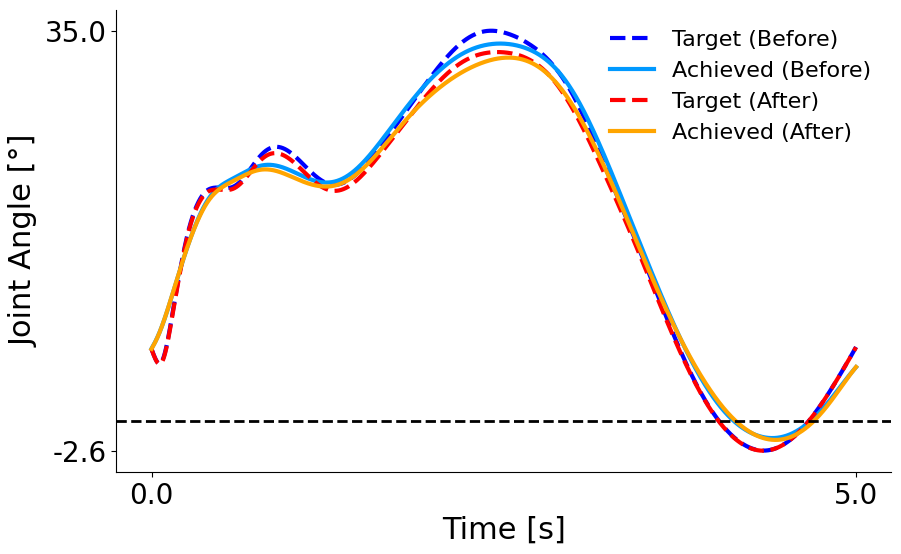

Muscle activation plot saved to outputs/muscle_activation_addlong_r_hip_psoas_r's_max_isometric_force_set_to_0.3.png


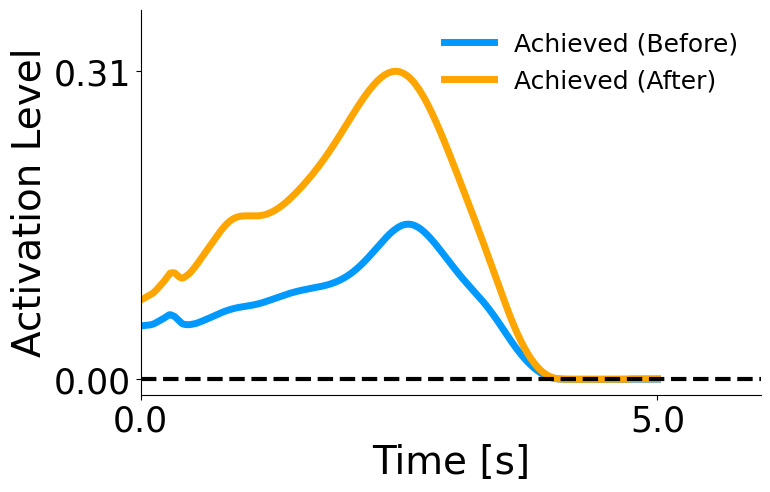

Muscle activation plot saved to outputs/muscle_activation_iliacus_r_hip_psoas_r's_max_isometric_force_set_to_0.3.png


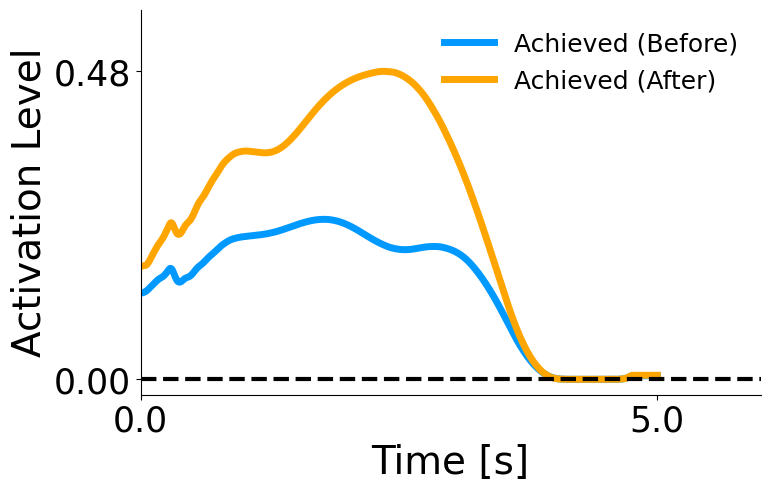

Muscle activation plot saved to outputs/muscle_activation_piri_r_hip_psoas_r's_max_isometric_force_set_to_0.3.png


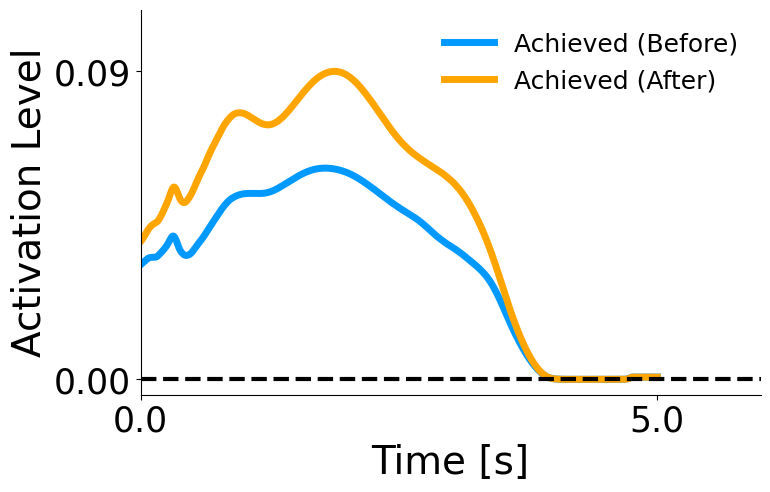

Muscle activation plot saved to outputs/muscle_activation_psoas_r_hip_psoas_r's_max_isometric_force_set_to_0.3.png


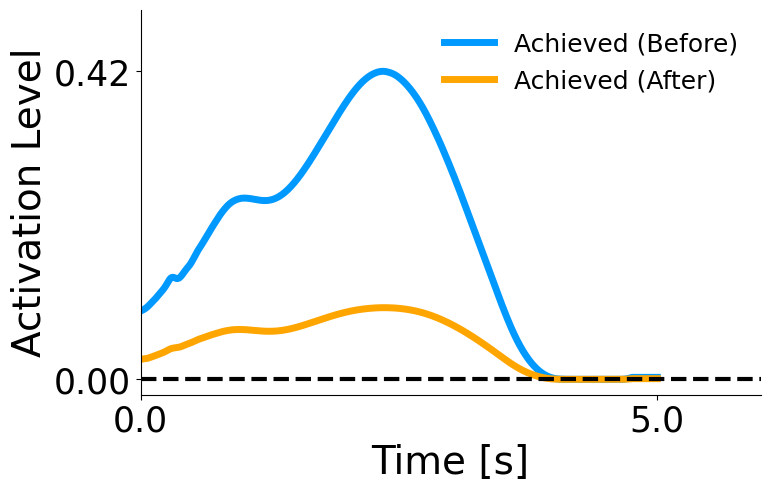

Analyzing knee with semimem_r's max_isometric_force scaled by 0.3.


100%|██████████| 5001/5001 [00:02<00:00, 2201.59it/s]


Kinematic comparison plot saved to outputs/kinematic_comparison_knee_semimem_r's_max_isometric_force_set_to_0.3.png


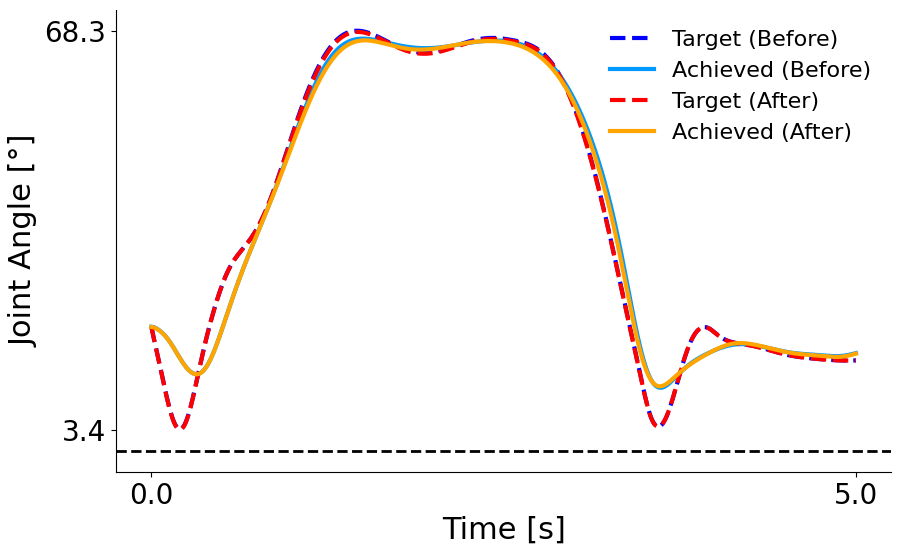

Muscle activation plot saved to outputs/muscle_activation_bflh_r_knee_semimem_r's_max_isometric_force_set_to_0.3.png


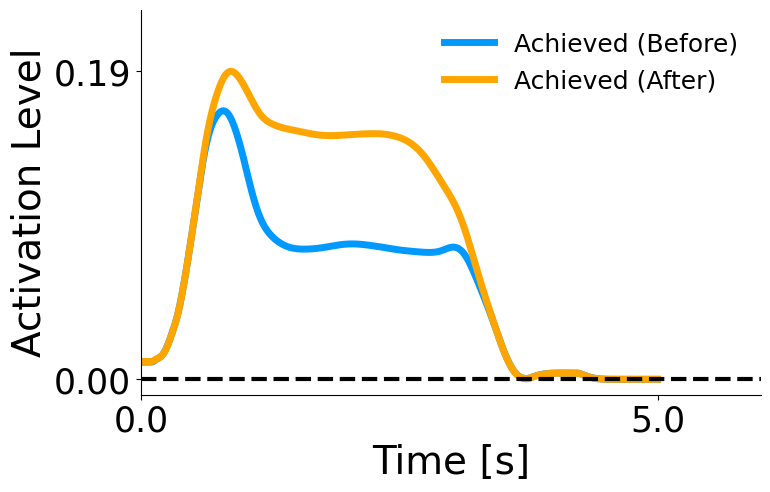

Muscle activation plot saved to outputs/muscle_activation_bfsh_r_knee_semimem_r's_max_isometric_force_set_to_0.3.png


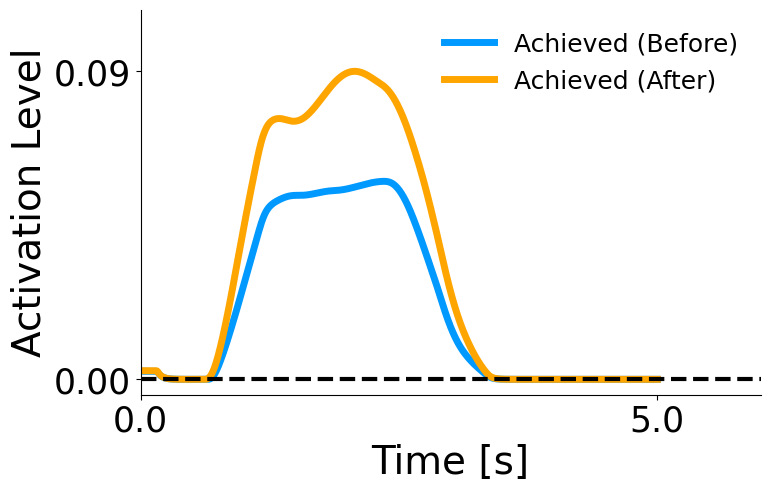

Muscle activation plot saved to outputs/muscle_activation_glmed1_r_knee_semimem_r's_max_isometric_force_set_to_0.3.png


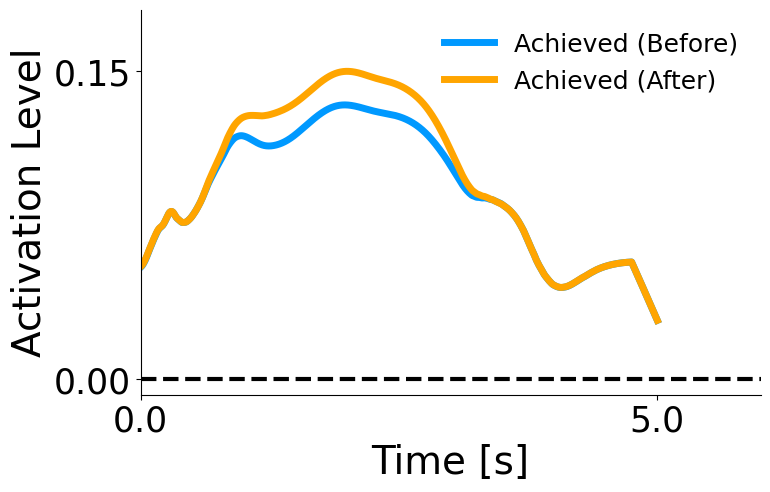

Muscle activation plot saved to outputs/muscle_activation_semimem_r_knee_semimem_r's_max_isometric_force_set_to_0.3.png


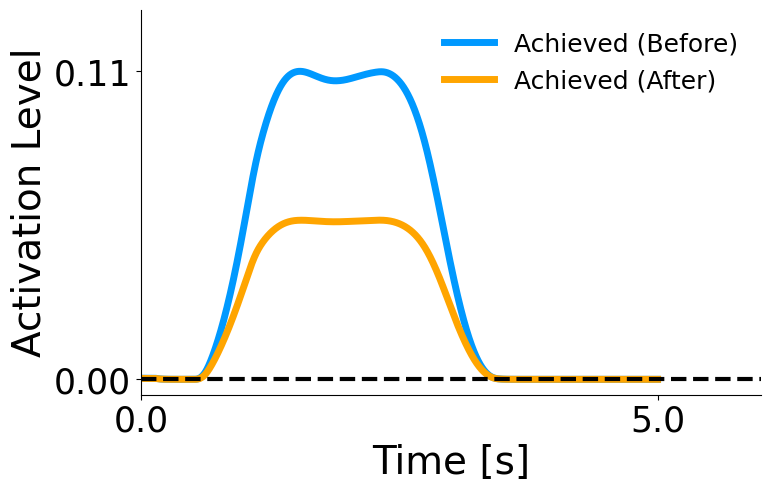

Muscle activation plot saved to outputs/muscle_activation_semiten_r_knee_semimem_r's_max_isometric_force_set_to_0.3.png


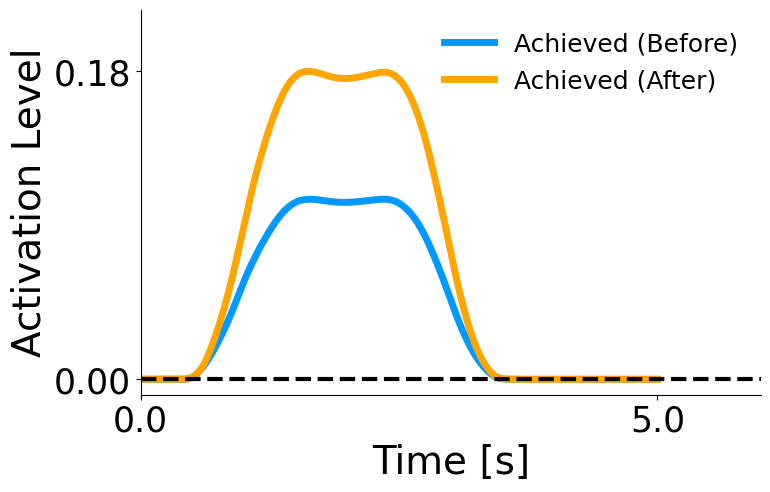

Analyzing ankle with tibant_r's max_isometric_force scaled by 0.3.


100%|██████████| 5001/5001 [00:02<00:00, 2308.26it/s]


Kinematic comparison plot saved to outputs/kinematic_comparison_ankle_tibant_r's_max_isometric_force_set_to_0.3.png


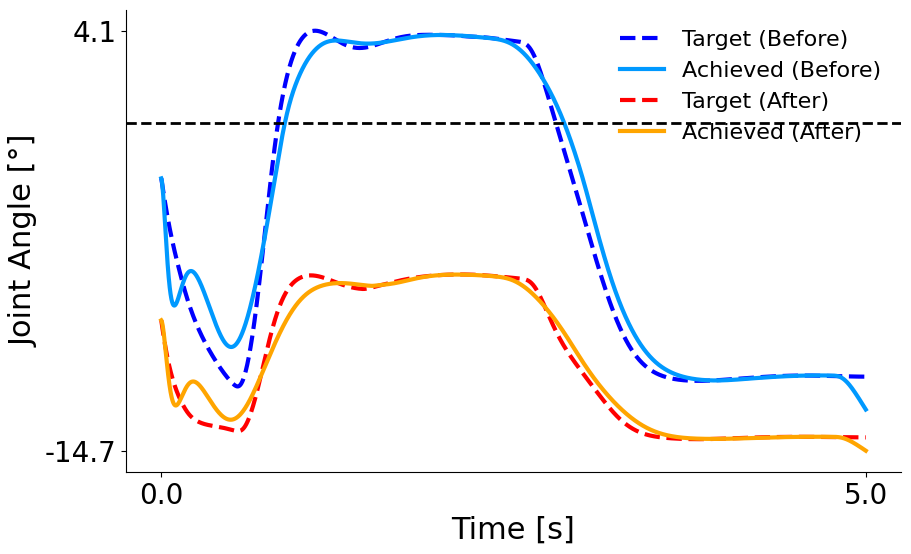

Muscle activation plot saved to outputs/muscle_activation_edl_r_ankle_tibant_r's_max_isometric_force_set_to_0.3.png


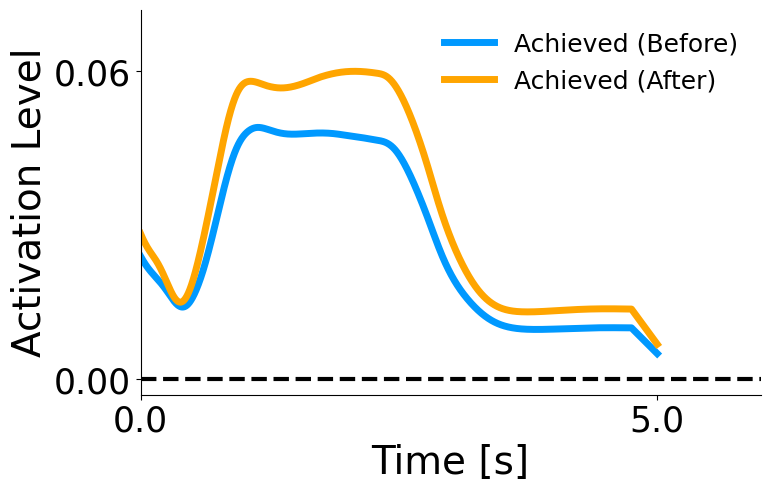

Muscle activation plot saved to outputs/muscle_activation_tibant_r_ankle_tibant_r's_max_isometric_force_set_to_0.3.png


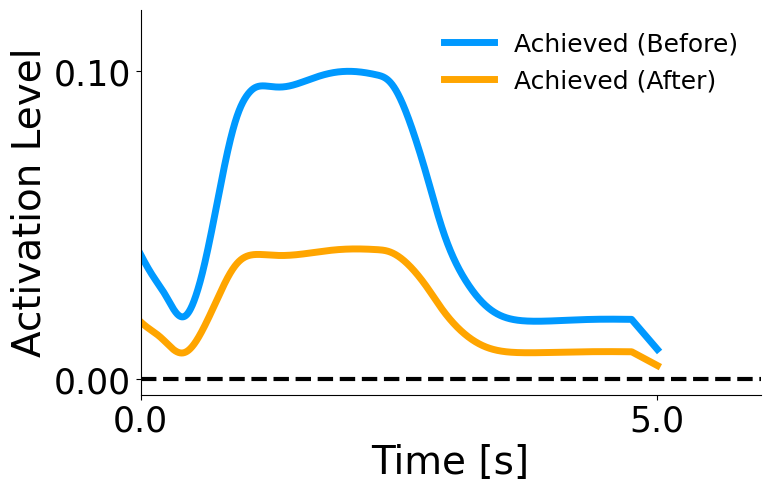

Muscle activation plot saved to outputs/muscle_activation_iliacus_l_ankle_tibant_r's_max_isometric_force_set_to_0.3.png


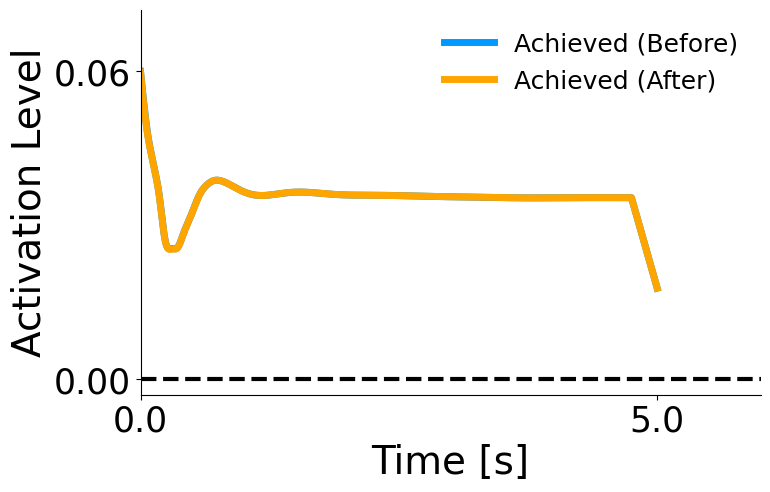

Muscle activation plot saved to outputs/muscle_activation_tibant_l_ankle_tibant_r's_max_isometric_force_set_to_0.3.png


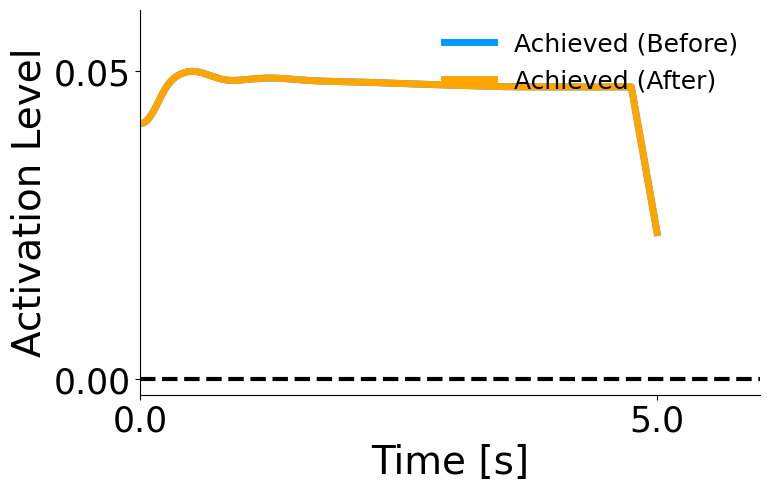

In [12]:
analyze_kinematics_and_activations(
    movement="hip",
    muscle_name="psoas_r",
    parameter_to_modify="max_isometric_force",
    scale_factor=0.3,
    activation_threshold=0.08
)

analyze_kinematics_and_activations(
    movement="knee",
    muscle_name="semimem_r",
    parameter_to_modify="max_isometric_force",
    scale_factor=0.3,
    activation_threshold=0.08
)

analyze_kinematics_and_activations(
    movement="ankle",
    muscle_name="tibant_r",
    parameter_to_modify="max_isometric_force",
    scale_factor=0.3,
    activation_threshold=0.05
)

## Muscle Synergies

### Define Kinematics and Sampling Parameters

In [13]:
# Define the kinematics for all tasks
kinematics_tasks = {
    "exc_before": {
        "hip": hip_f_values_exc_before,
        "knee": knee_f_values_exc_before,
        "ankle": ankle_d_values_exc_before
    },
    "exc_after": {
        "hip": hip_f_values_exc_after,
        "knee": knee_f_values_exc_after,
        "ankle": ankle_d_values_exc_after
    }
}

# Sampling frequency and trajectory parameters
fs = 500  # Sampling frequency [Hz]
duration = 5  # Total duration [s]
n_samples = int(fs * duration)  # Number of samples
qidxs_of_interest = np.array([0, 5, 8])  # Indices of joints to be controlled

### Compute Activations for All Tasks and Movements

In [14]:
# Dictionary to store activations for each task and movement
activations_dict = {}

for task, kinematics in kinematics_tasks.items():
    for movement_key, movement_name in joint_mappings.items():
        print(f"Processing task: {task}, movement: {movement_name}")

        # Prepare the trajectory
        traj = np.zeros((n_samples, 3))
        movement_keys_list = list(joint_mappings.keys())
        if movement_key in kinematics:
            traj[:, movement_keys_list.index(movement_key)] = np.degrees(
                interpolate(kinematics[movement_key], n_samples)
            )

        # Compute activations using inverse dynamics
        activations, _, _ = inverse_dynamics(
            traj=traj, qidxs_of_interest=qidxs_of_interest, fs=fs, task=task, movement=movement_name
        )

        # Store activations in the dictionary
        activations_dict[f"activations_{task}_{movement_key}"] = activations

Processing task: exc_before, movement: Hip Flexion


100%|██████████| 5501/5501 [00:09<00:00, 567.34it/s]


Processing task: exc_before, movement: Knee Flexion


100%|██████████| 5501/5501 [00:09<00:00, 574.44it/s]


Processing task: exc_before, movement: Ankle Dorsiflexion


100%|██████████| 5501/5501 [00:09<00:00, 558.09it/s]


Processing task: exc_after, movement: Hip Flexion


100%|██████████| 5501/5501 [00:09<00:00, 571.31it/s]


Processing task: exc_after, movement: Knee Flexion


100%|██████████| 5501/5501 [00:09<00:00, 564.19it/s]


Processing task: exc_after, movement: Ankle Dorsiflexion


100%|██████████| 5501/5501 [00:09<00:00, 579.75it/s]


### Compute Muscle Synergies

In [15]:
def compute_muscle_synergies(activations, max_components=10, r2_threshold=0.8):

    r2_values = []
    optimal_components = None

    # Ensure activations are non-negative
    activations = np.maximum(activations, 0)

    # Normalize activations
    activations_normalized = activations / np.max(activations)

    for n_components in range(1, max_components + 1):
        nmf = NMF(n_components=n_components, init='random', random_state=1, max_iter=20000, l1_ratio=0.8)
        W = nmf.fit_transform(activations_normalized)
        H = nmf.components_

        # Reconstruct the activations
        reconstructed = np.dot(W, H)

        # Compute R²
        r2 = r2_score(activations_normalized, reconstructed)
        r2_values.append(r2)

        # Check if R² exceeds the threshold
        if r2 >= r2_threshold and optimal_components is None:
            optimal_components = n_components

    # If no optimal components found, use the maximum number of components
    if optimal_components is None:
        optimal_components = max_components

    # Compute the final NMF with the optimal number of components
    nmf_opt = NMF(n_components=optimal_components, init='random', random_state=1, max_iter=20000, l1_ratio=0.8)
    W = nmf_opt.fit_transform(activations_normalized)
    H = nmf_opt.components_

    return W, H, optimal_components, r2_values

### Helper Functions

In [42]:
def synergies_info(W, H, r2_values, optimal_components, movement_description, task_description, output_folder="outputs"): 
    # Create the output folder if it doesn't exist 
    os.makedirs(output_folder, exist_ok=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))

    # Calculate global max for y-axis across all synergies
    global_y_max_h = np.max(H)  # Max value for H plot
    global_y_max_w = np.max(W, axis=0).max()  # Max value for W plot (highest value across all curves over time)

    # Plot R² values
    axs[0].plot(range(1, len(r2_values) + 1), r2_values, marker='o')
    axs[0].axhline(y=0.8, color='r', linestyle='--', label='R² Threshold (0.8)')
    axs[0].set_xlabel("Number of Components", fontsize=30)
    axs[0].set_ylabel("R² Value", fontsize=30)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].legend(fontsize=20, ncol=2, frameon=False)  # Bigger legend, no box

    # Customize ticks: Only min and max for x and y axes
    axs[0].set_xticks([1, len(r2_values)])
    axs[0].set_xticklabels([1, len(r2_values)], fontsize=25)
    axs[0].set_yticks([0, max(r2_values)])
    axs[0].set_yticklabels([f"{0:.1f}", f"{max(r2_values):.1f}"], fontsize=25)

    # Plot muscle synergies (W)
    for i in range(optimal_components):
        axs[1].plot(W[:, i], label=f"Synergy {i + 1}", alpha=1.0, linewidth=2.0)
    axs[1].set_xlabel("Time Steps", fontsize=30)
    axs[1].set_ylabel("Synergy Activation", fontsize=30)
    axs[1].legend(fontsize=20, ncol=2, loc="upper right", frameon=False)  # Bigger legend, no box
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].tick_params(axis='both', which='major', labelsize=25)

    # Customize ticks: Only min and max for x and y axes
    axs[1].set_xticks([0, W.shape[0] - 1])
    axs[1].set_xticklabels([0, W.shape[0] - 1], fontsize=25)
    axs[1].set_yticks([0, global_y_max_w])
    axs[1].set_yticklabels([f"{0:.1f}", f"{global_y_max_w:.1f}"], fontsize=25)

    # Plot activation coefficients (H)
    for i in range(optimal_components):
        axs[2].bar(range(1, H.shape[1] + 1), H[i, :], label=f"Synergy {i + 1}", alpha=1.0)  # Adjusted x-axis to start from 1
    axs[2].set_xlabel("Muscles", fontsize=30)
    axs[2].set_ylabel("Activation Coefficients", fontsize=30)
    axs[2].legend(fontsize=20, ncol=1, loc="upper right", frameon=False)  # Bigger legend, no box
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)

    # Customize ticks: Only min and max for x and y axes
    axs[2].set_xticks([1, H.shape[1]])
    axs[2].set_xticklabels([1, H.shape[1]], fontsize=25)
    axs[2].set_yticks([0, global_y_max_h])
    axs[2].set_yticklabels([f"{0:.1f}", f"{global_y_max_h:.1f}"], fontsize=25)

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])

    # Save the plot
    filename = os.path.join(output_folder, f"synergy_results_{movement_description.replace(' ', '_')}_{task_description.replace(' ', '_')}.png")
    plt.savefig(filename)
    print(f"Synergy results plot saved to {filename}")

    plt.show()
    plt.close()


def plot_activation_coefficients_combined(H, movement_description, task_description, output_folder="outputs"):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Define muscle groups and assign colors
    muscle_groups = {
        "Hip Extensors": ['glmax1', 'glmax2', 'glmax3', 'semimem', 'semiten', 'bflh', 'addmagisch', 'addmagprox'],
        "Hip Flexors": ['psoas', 'iliacus', 'recfem', 'sart', 'tfl'],
        "Hip Abductors": ['glmed1', 'glmed2', 'glmed3', 'glmin1', 'glmin2', 'glmin3', 'tfl', 'piri'],
        "Hip Adductors": ['addbrev', 'addlong', 'addmagmid', 'addmagdist', 'grac'],
        "Knee Extensors": ['vaslat', 'vasmed', 'vasint', 'recfem'],
        "Knee Flexors": ['semimem', 'semiten', 'bflh', 'bfsh', 'grac', 'sart', 'gaslat', 'gasmed'],
        "Plantar Flexors": ['soleus', 'gaslat', 'gasmed', 'tibpost', 'fhl', 'fdl', 'perlong', 'perbrev'],
        "Dorsiflexors": ['tibant', 'edl', 'ehl']
    }
    group_colors = {
        "Hip Extensors": 'green', "Hip Flexors": 'olive', "Hip Abductors": 'blue', "Hip Adductors": 'cyan',
        "Knee Extensors": 'orange', "Knee Flexors": 'red', "Plantar Flexors": 'brown', "Dorsiflexors": 'pink'
    }
    muscle_colors = {muscle: group_colors[group] for group, muscles in muscle_groups.items() for muscle in muscles}

    # Generate the full list of muscle names (left and right)
    muscle_names = [f"{muscle}_r" for muscle in muscle_colors.keys()] + [f"{muscle}_l" for muscle in muscle_colors.keys()]

    # Ensure the number of muscles matches the number of columns in H
    if len(muscle_names) != H.shape[1]:
        raise ValueError(f"Mismatch between muscle names ({len(muscle_names)}) and activation coefficients ({H.shape[1]}).")

    n_synergies = H.shape[0]
    fig, axs = plt.subplots(n_synergies, 1, figsize=(16, 5 * n_synergies))

    for synergy_idx in range(n_synergies):
        ax = axs[synergy_idx] if n_synergies > 1 else axs

        # Get the activation coefficients for the current synergy
        activation_coefficients = H[synergy_idx, :]
        max_activation = np.max(activation_coefficients)

        # Filter muscles with activation coefficients >= 5% of the maximum
        threshold = 0.05 * max_activation
        filtered_indices = np.where(activation_coefficients >= threshold)[0]
        filtered_coefficients = activation_coefficients[filtered_indices]
        filtered_muscle_names = [muscle_names[i] for i in filtered_indices]
        filtered_colors = [muscle_colors.get(muscle.split('_')[0], 'gray') for muscle in filtered_muscle_names]

        # Plot the filtered muscles
        ax.bar(range(len(filtered_muscle_names)), filtered_coefficients, color=filtered_colors, alpha=0.7)
        ax.set_title(f"Synergy {synergy_idx + 1} Activation Coefficients", fontsize=14)
        ax.set_ylabel("Coefficient")
        ax.set_xticks(range(len(filtered_muscle_names)))
        ax.set_xticklabels(filtered_muscle_names, rotation=90, fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add a proper legend for muscle groups
        handles = [plt.Line2D([0], [0], color=color, lw=4, label=group) for group, color in group_colors.items()]
        ax.legend(handles=handles, fontsize=8, loc='upper right', ncol=2)

    fig.suptitle(f"Activation Coefficients for All Synergies - {movement_description} ({task_description})", fontsize=20, y=1.02)
    plt.tight_layout(rect=[0, 0.05, 1, 1.02])

    # Save the plot
    filename = os.path.join(output_folder, f"activation_coefficients_{movement_description.replace(' ', '_')}_{task_description.replace(' ', '_')}.png")
    plt.savefig(filename)
    print(f"Activation coefficients plot saved to {filename}")

    plt.show()
    plt.close()

### Analyze Synergies

In [43]:
def analyze_synergies(task, movement):
    """
    Analyzes muscle synergies for a given task and movement.

    Parameters:
    - task (str): The task to analyze (e.g., "exc_before", "exc_after").
    - movement (str): The movement to analyze (e.g., "hip", "knee", "ankle").
    """
    # Map task and movement to descriptive labels
    task_descriptions = {
        "exc_before": "excitation before parameter change",
        "exc_after": "excitation after parameter change"
    }
    joint_mappings = {
        "hip": "Hip Flexion",
        "knee": "Knee Flexion",
        "ankle": "Ankle Dorsiflexion"
    }

    # Get human-readable descriptions
    movement_description = joint_mappings[movement]
    task_description = task_descriptions[task]

    print(f"Processing task: {task}, movement: {movement}")

    # Access the activations for the current task and movement
    key = f"activations_{task}_{movement}"
    activations = activations_dict[key]

    # Compute muscle synergies
    W, H, optimal_components, r2_values = compute_muscle_synergies(activations)

    print(f"--> Optimal number of components: {optimal_components}")
    print(f"--> R² values: {[f'{r2:.3f}' for r2 in r2_values]}")

    # Plot R² values, muscle synergies (W), and activation coefficients (H)
    synergies_info(W, H, r2_values, optimal_components, movement_description, task_description)

    # Plot activation coefficients grouped by muscle groups
    plot_activation_coefficients_combined(H, movement_description, task_description)

Processing task: exc_before, movement: ankle
--> Optimal number of components: 3
--> R² values: ['-0.741', '0.362', '0.827', '0.901', '0.940', '0.953', '0.974', '0.974', '0.979', '0.978']
Synergy results plot saved to outputs/synergy_results_Ankle_Dorsiflexion_excitation_before_parameter_change.png


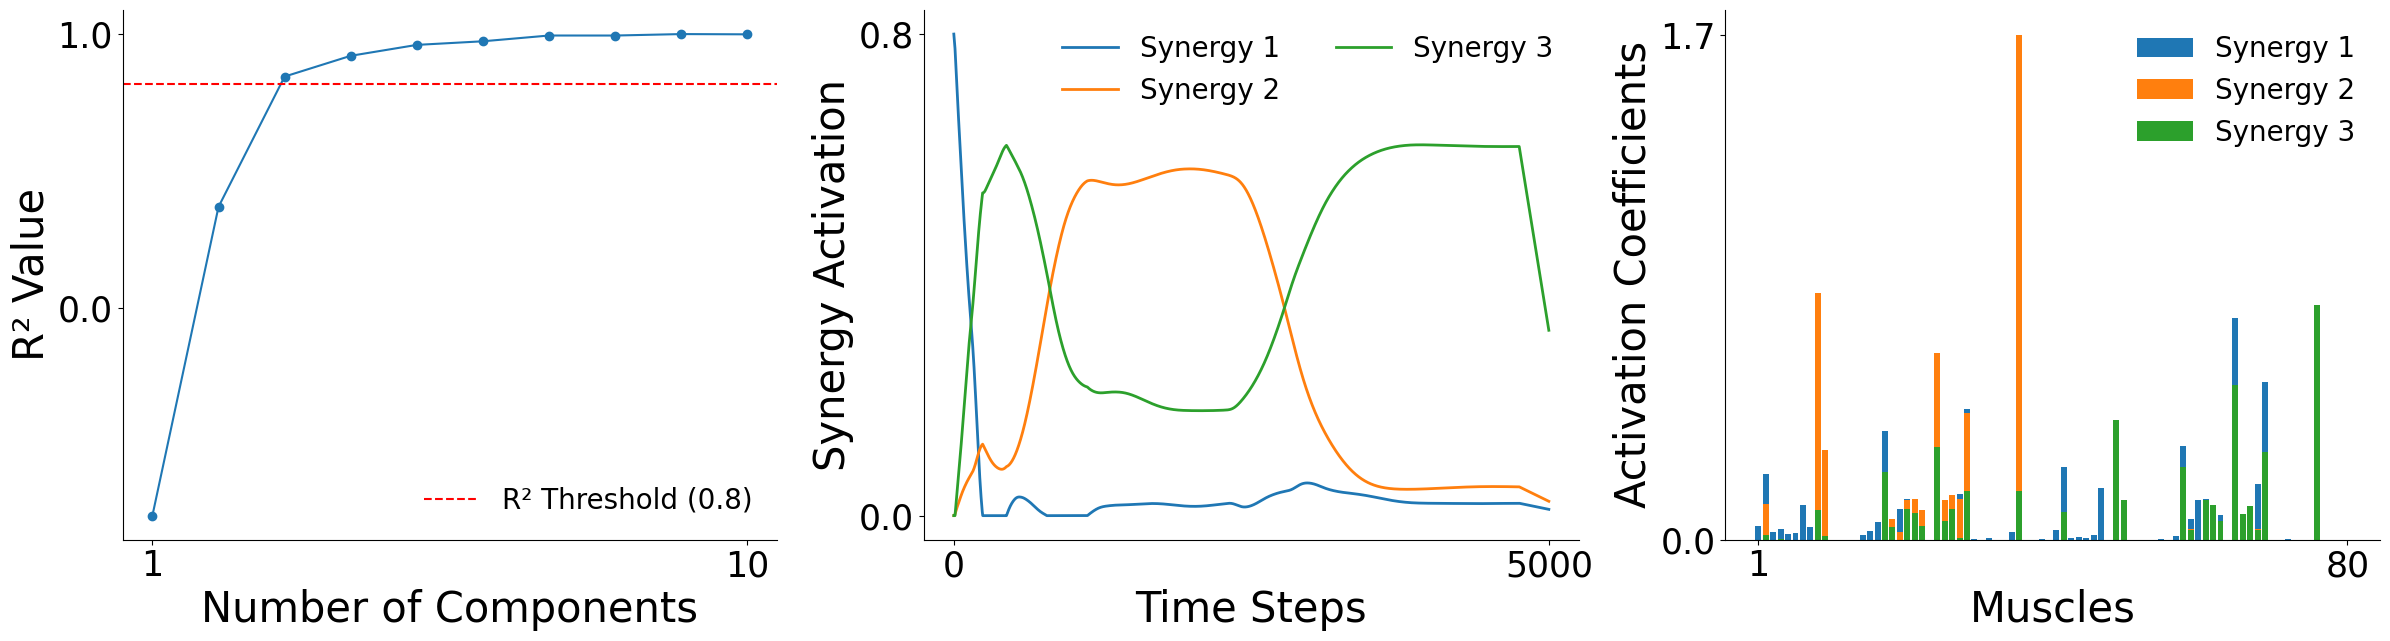

Activation coefficients plot saved to outputs/activation_coefficients_Ankle_Dorsiflexion_excitation_before_parameter_change.png


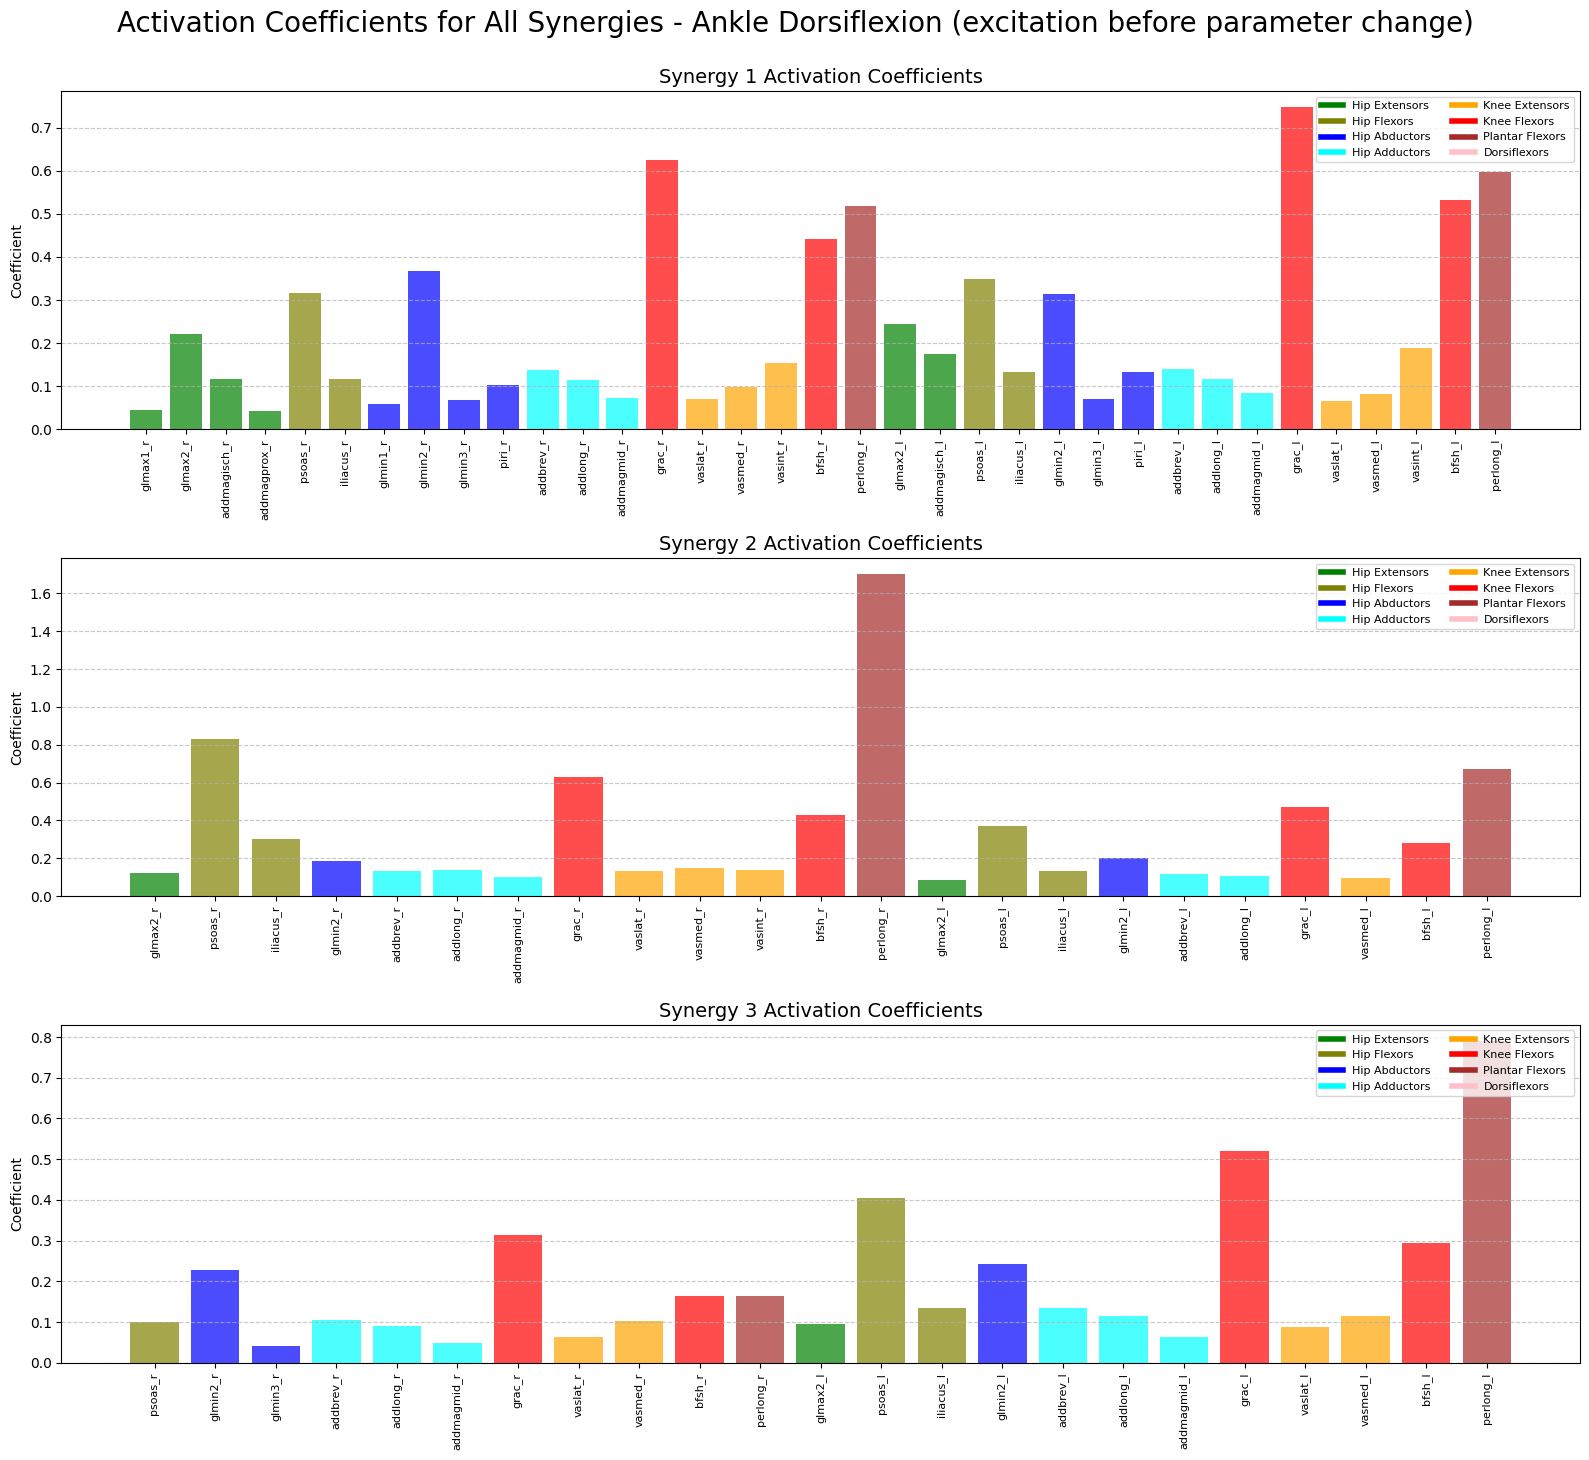

Processing task: exc_after, movement: ankle
--> Optimal number of components: 3
--> R² values: ['0.041', '0.333', '0.824', '0.900', '0.937', '0.952', '0.974', '0.979', '0.975', '0.982']
Synergy results plot saved to outputs/synergy_results_Ankle_Dorsiflexion_excitation_after_parameter_change.png


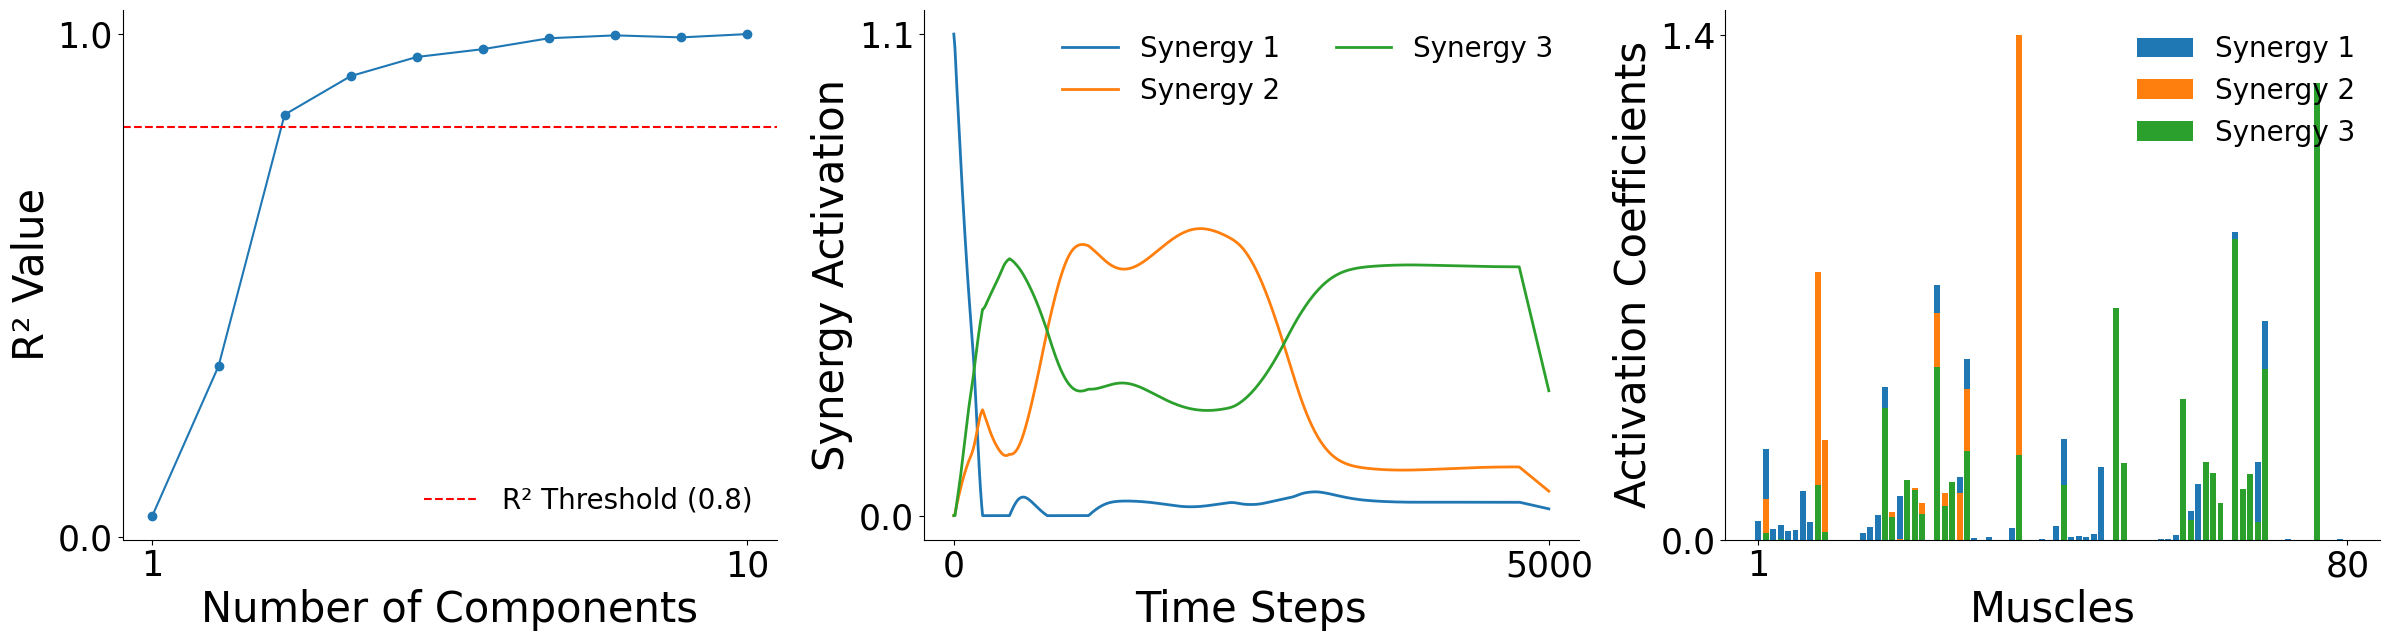

Activation coefficients plot saved to outputs/activation_coefficients_Ankle_Dorsiflexion_excitation_after_parameter_change.png


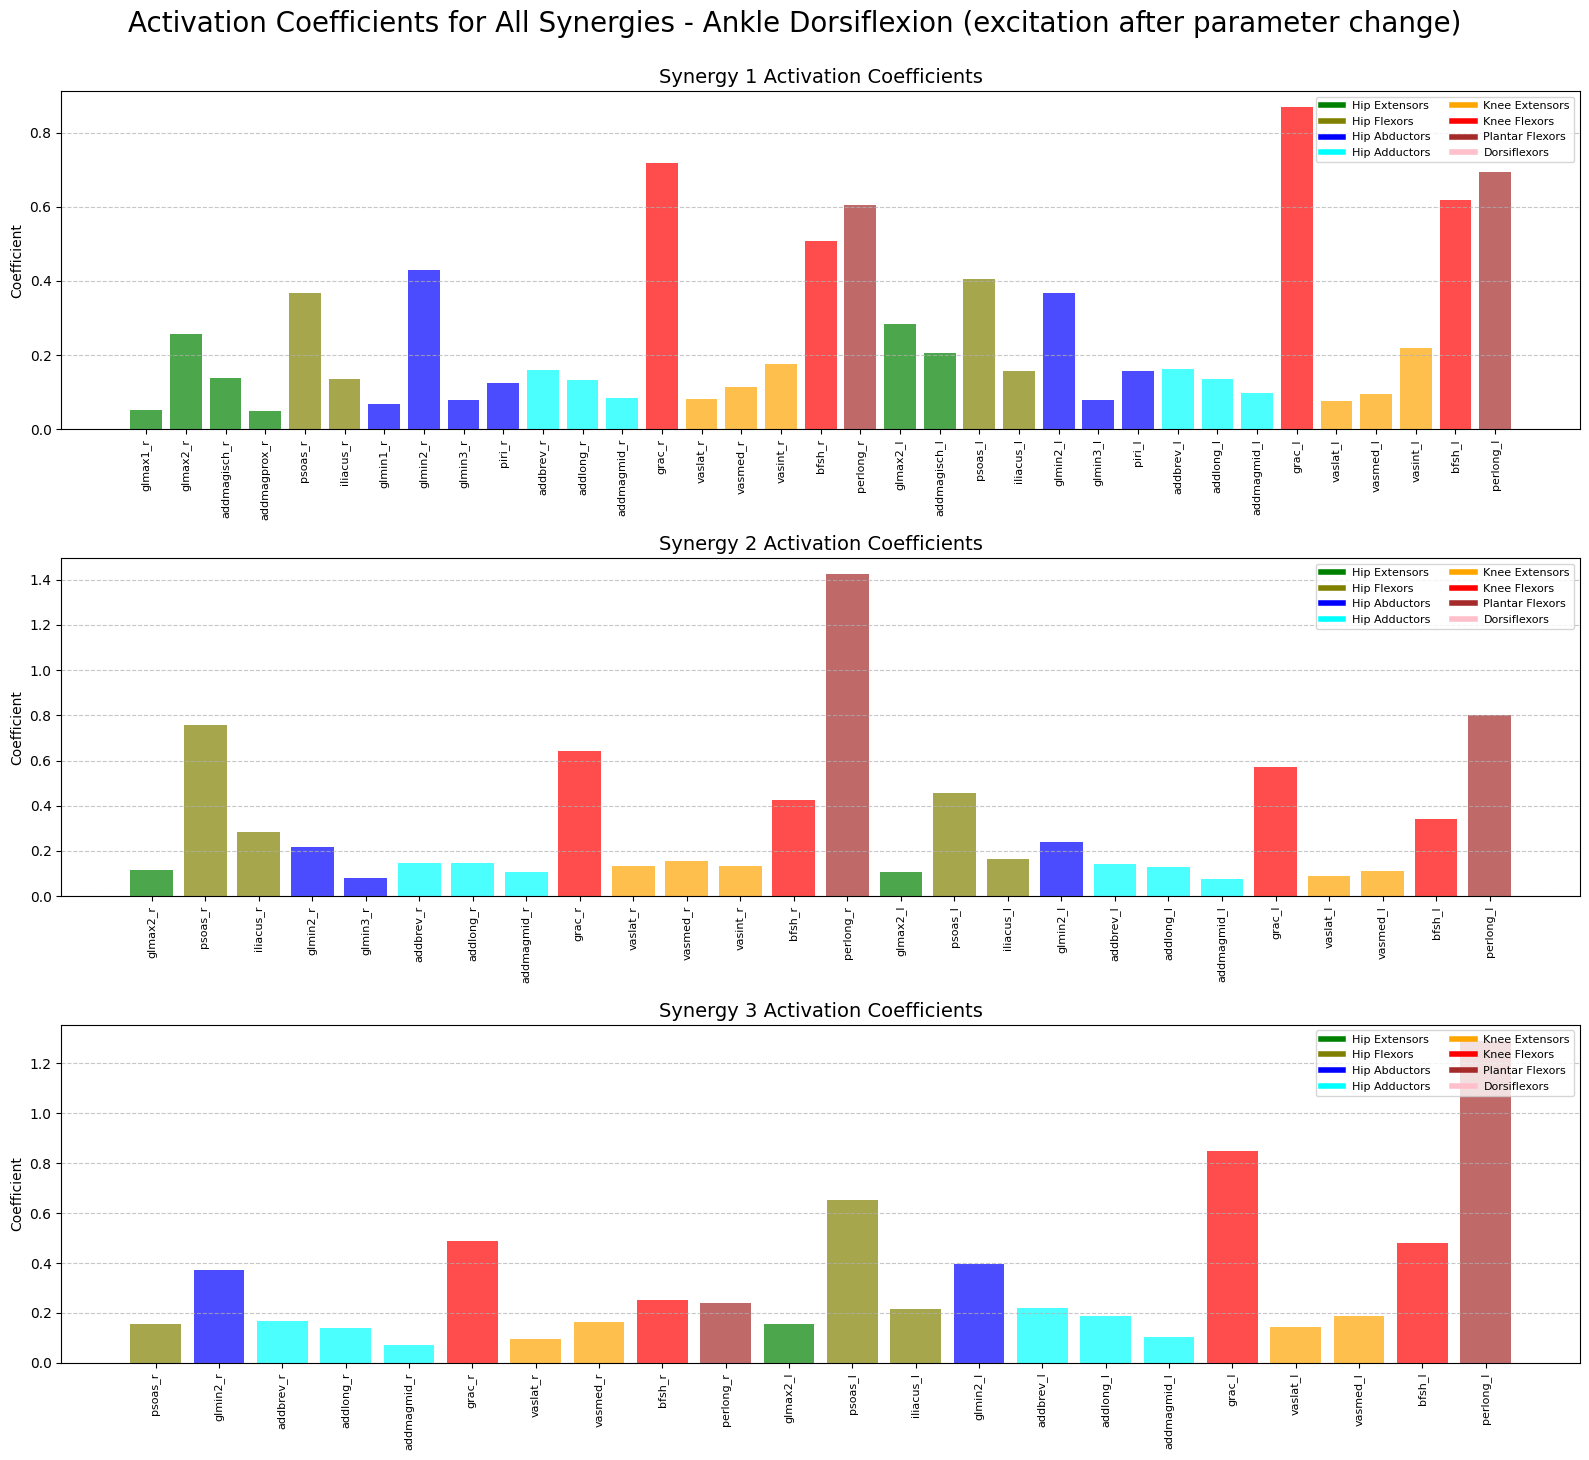

In [44]:
# Analyze synergies for all tasks and movements
for task in ["exc_before", "exc_after"]:
    for movement in ["ankle"]:
        analyze_synergies(task=task, movement=movement)

___

In [19]:
# Load the datasets
dataset_left = np.load("dataset_left_H14.npz")
dataset_right = np.load("dataset_right_H14.npz")

# Inspect the contents of the datasets
print("Keys in dataset_left_H14.npz:", dataset_left.files)
print("Keys in dataset_right_H14.npz:", dataset_right.files)

# Extract relevant variables for the full gait cycle
variables_to_plot = ['hip_angle', 'knee_angle', 'ankle_angle']
left_gait_cycle = {var: dataset_left[var] for var in variables_to_plot}
right_gait_cycle = {var: dataset_right[var] for var in variables_to_plot}

Keys in dataset_left_H14.npz: ['pitch_foot', 'vert_acc_foot', 'pitch_femur', 'vert_acc_femur', 'pitch_tibia', 'vert_acc_tibia', 'pitch_trunk', 'vert_acc_trunk', 'ankle_angle', 'knee_angle', 'hip_angle', 'hip_abduction', 'hip_rotation', 'pitch', 'sagittal_velocity', 'vert_acc', 'ant_post_acc', 'norm_global_acceleration', 'time']
Keys in dataset_right_H14.npz: ['pitch_foot', 'vert_acc_foot', 'pitch_femur', 'vert_acc_femur', 'pitch_tibia', 'vert_acc_tibia', 'pitch_trunk', 'vert_acc_trunk', 'ankle_angle', 'knee_angle', 'hip_angle', 'hip_abduction', 'hip_rotation', 'pitch', 'sagittal_velocity', 'vert_acc', 'ant_post_acc', 'norm_global_acceleration', 'time']


Hip Gait Cycle Start Times: [352, 486, 616, 745, 875, 1002, 1134, 1259, 1389, 1512, 1655, 1772, 1897]
Knee Gait Cycle Start Times: [335, 470, 599, 728, 858, 986, 1117, 1243, 1373, 1497, 1625, 1753, 1879, 2011]
Ankle Gait Cycle Start Times: [309, 448, 577, 706, 834, 962, 1093, 1220, 1350, 1473, 1604, 1732, 1858, 1988]


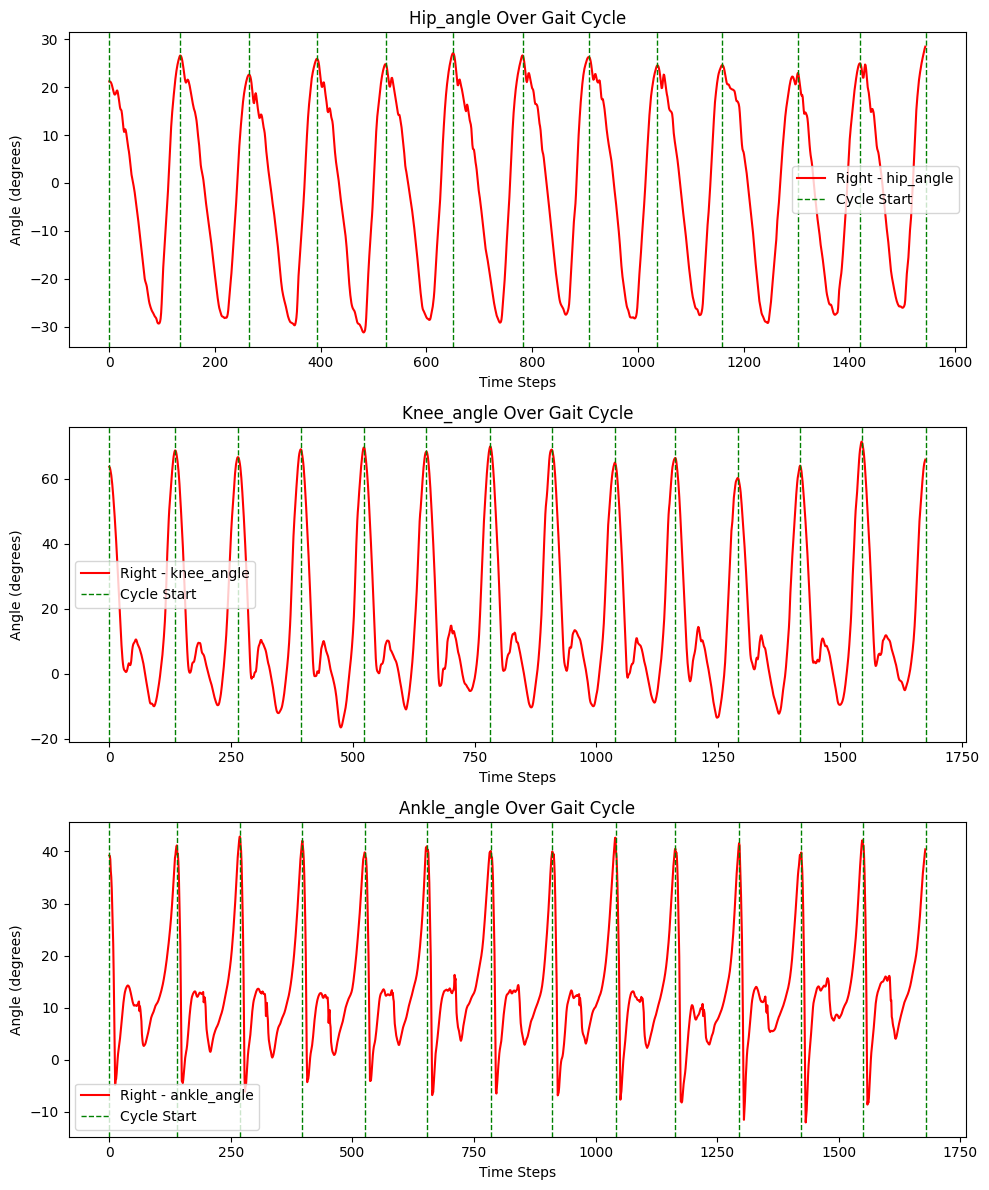

In [20]:
from scipy.signal import find_peaks

def identify_gait_cycle_start_times(angle_array, threshold=None, prominence=0.5, distance=100):
    """
    Identifies the time steps where a new gait cycle begins based on the input angle array.

    Parameters:
    - angle_array (numpy.ndarray): Array of angle values over time (e.g., hip, knee, or ankle angle).
    - threshold (float, optional): Threshold to filter peaks (default is None, no filtering).
    - prominence (float): Minimum prominence of peaks to identify cycles.
    - distance (int): Minimum distance between peaks to avoid over-segmentation.

    Returns:
    - start_times (list): List of time steps where a new gait cycle begins.
    """
    # Normalize the angle array to the range [0, 1]
    angle_normalized = (angle_array - np.min(angle_array)) / (np.max(angle_array) - np.min(angle_array))

    # Find peaks in the normalized angle array
    peak_indices, properties = find_peaks(angle_normalized, prominence=prominence, distance=distance)

    # Filter peaks based on threshold (if provided)
    if threshold is not None:
        peak_indices = [idx for idx in peak_indices if angle_normalized[idx] > threshold]

    # Return the time steps where a new cycle begins
    return peak_indices


# Extract the angle data from the dataset
hip_angle = dataset_right['hip_angle']
knee_angle = dataset_right['knee_angle']
ankle_angle = dataset_right['ankle_angle']

# Define parameters for identifying gait cycle start times
threshold = 0.2  # Example threshold for normalized knee angle
prominence = 0.5  # Minimum prominence of peaks
distance = 100  # Minimum distance between peaks

# Identify gait cycle start times for each angle
hip_start_times = identify_gait_cycle_start_times(hip_angle, threshold=threshold, prominence=prominence, distance=distance)
knee_start_times = identify_gait_cycle_start_times(knee_angle, threshold=threshold, prominence=prominence, distance=distance)
ankle_start_times = identify_gait_cycle_start_times(ankle_angle, threshold=threshold, prominence=prominence, distance=distance)

# Trim data to include only values between the first and last cycle start times
hip_angle = hip_angle[hip_start_times[0]:hip_start_times[-1]]
knee_angle = knee_angle[knee_start_times[0]:knee_start_times[-1]]
ankle_angle = ankle_angle[ankle_start_times[0]:ankle_start_times[-1]]

# Print the identified start times
print("Hip Gait Cycle Start Times:", hip_start_times)
print("Knee Gait Cycle Start Times:", knee_start_times)
print("Ankle Gait Cycle Start Times:", ankle_start_times)

# Select variables to plot
variables_to_plot = ['hip_angle', 'knee_angle', 'ankle_angle']
start_times_dict = {
    'hip_angle': hip_start_times,
    'knee_angle': knee_start_times,
    'ankle_angle': ankle_start_times
}

plt.figure(figsize=(10, 12))  # Adjust figure size for 3 rows, 1 column
for i, variable in enumerate(variables_to_plot):
    plt.subplot(len(variables_to_plot), 1, i + 1)  # Create 3 rows, 1 column subplots
    plt.plot(dataset_right[variable][start_times_dict[variable][0]:start_times_dict[variable][-1]], label=f"Right - {variable}", color="red")

    # Plot vertical lines at movement start indices for the current angle
    label_added = False  # Track whether the label has been added
    for start_time in start_times_dict[variable]:
        if not label_added:
            plt.axvline(x=start_time - start_times_dict[variable][0], color='green', linestyle='--', linewidth=1, label='Cycle Start')
            label_added = True  # Add the label only once
        else:
            plt.axvline(x=start_time - start_times_dict[variable][0], color='green', linestyle='--', linewidth=1)

    plt.title(f"{variable.capitalize()} Over Gait Cycle")
    plt.xlabel("Time Steps")
    plt.ylabel("Angle (degrees)")
    plt.legend()

plt.tight_layout()
plt.show()

In [21]:
def plot_synergy_muscle_activations(time, activations, H, muscle_name_list, movement_description, task_description, output_folder="outputs", start_times=None):
    """
    Plots the muscle activation levels over time for the top 8 muscles involved in each synergy,
    including mean and standard deviation across repetitions of movements in the gait cycle.

    Parameters:
    - time (numpy.ndarray): Time steps corresponding to the activations.
    - activations (numpy.ndarray): Muscle activation data (time steps × muscles).
    - H (numpy.ndarray): Activation coefficients (synergies × muscles).
    - muscle_name_list (list): List of muscle names corresponding to columns in activations.
    - movement_description (str): Human-readable movement description.
    - task_description (str): Human-readable task description.
    - output_folder (str): Folder to save the plot.
    - start_times (list): List of time steps where a new gait cycle begins.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    n_synergies = H.shape[0]  # Number of synergies

    # Compute the end times based on start times
    end_times = start_times[1:] + [activations.shape[0]]  # Add the last time step as the end of the final cycle

    for synergy_idx in range(n_synergies):
        # Identify the top 8 muscles involved in the current synergy
        activation_coefficients = H[synergy_idx, :]
        top_indices = np.argsort(activation_coefficients)[-8:]  # Indices of the top 8 muscles
        top_muscles = [muscle_name_list[i] for i in top_indices]  # Map indices to muscle names

        if not top_muscles:
            print(f"No muscles exceeded the threshold for Synergy {synergy_idx + 1}.")
            continue

        # Determine the shared y-axis range
        max_activation_level = np.max([np.max(activations[:, i]) for i in top_indices])
        y_min, y_max = -0.05, max_activation_level + 0.05

        # Plot muscle activations for each top muscle
        ncols = min(len(top_muscles), 4)
        nrows = int(np.ceil(len(top_muscles) / ncols))
        fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)
        axs = axs.flatten()

        for idx, muscle_idx in enumerate(top_indices):
            ax = axs[idx]

            # Extract activations for the muscle across all repetitions of the gait cycle
            muscle_activations_repetitions = []
            segment_lengths = []  # Track the lengths of all segments

            for start, end in zip(start_times_dict[movement_description], start_times_dict[movement_description][1:] + [activations.shape[0]]):
                segment = activations[start:end, muscle_idx]
                muscle_activations_repetitions.append(segment)
                segment_lengths.append(segment.shape[0])  # Store the length of the segment

            # Determine the minimum segment length
            min_length = min(segment_lengths)

            # Truncate all segments to the minimum length
            muscle_activations_repetitions = [segment[:min_length] for segment in muscle_activations_repetitions]

            # Stack activations into a 2D array (repetitions × time steps)
            muscle_activations_repetitions = np.vstack(muscle_activations_repetitions)

            # Compute mean and std across repetitions
            mean_activation = np.mean(muscle_activations_repetitions, axis=0)
            std_activation = np.std(muscle_activations_repetitions, axis=0)

            # Plot mean and std as shaded region
            ax.plot(np.arange(mean_activation.shape[0]), mean_activation, linewidth=1.5, color='blue', label=f"{top_muscles[idx]} Mean")
            ax.fill_between(np.arange(mean_activation.shape[0]), mean_activation - std_activation, mean_activation + std_activation,
                            color='blue', alpha=0.3, label=f"{top_muscles[idx]} ± Std")

            ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
            ax.set_title(top_muscles[idx], fontsize=10)
            ax.set_ylim(y_min, y_max)
            ax.spines.top.set_visible(False)
            ax.spines.right.set_visible(False)

        # Turn off unused subplots
        for j in range(len(top_indices), len(axs)):
            axs[j].axis('off')

        fig.text(0.5, 0.04, "Time Steps", ha='center', fontsize=12)
        fig.text(0.04, 0.5, "Muscle Activation Level", va='center', rotation='vertical', fontsize=12)
        fig.suptitle(f"Top 8 Muscle Activations for Synergy {synergy_idx + 1} - {movement_description} ({task_description})", fontsize=16)
        plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])

        # Save the plot
        filename = os.path.join(output_folder, f"synergy_{synergy_idx + 1}_top_muscle_activations_{movement_description.replace(' ', '_')}_{task_description.replace(' ', '_')}.png")
        plt.savefig(filename)
        print(f"Top muscle activations plot for Synergy {synergy_idx + 1} saved to {filename}")

        plt.show()
        plt.close()

In [22]:
def analyze_synergies(task, movement):
    """
    Analyzes muscle synergies for a given task and movement.

    Parameters:
    - task (str): The task to analyze (e.g., "exc_before", "exc_after").
    - movement (str): The movement to analyze (e.g., "hip", "knee", "ankle").
    """
    # Map task and movement to descriptive labels
    task_descriptions = {
        "exc_before": "excitation before parameter change",
        "exc_after": "excitation after parameter change"
    }
    joint_mappings = {
        "hip": "hip_angle",
        "knee": "knee_angle",
        "ankle": "ankle_angle"
    }

    # Get human-readable descriptions
    movement_description = joint_mappings[movement]
    task_description = task_descriptions[task]

    print(f"Processing task: {task}, movement: {movement}")

    # Access the activations for the current task and movement
    key = f"activations_{task}_{movement}"
    activations = activations_dict[key]

    # Compute muscle synergies
    W, H, optimal_components, r2_values = compute_muscle_synergies(activations)

    print(f"--> Optimal number of components: {optimal_components}")
    print(f"--> R² values: {[f'{r2:.3f}' for r2 in r2_values]}")

    # Plot R² values, muscle synergies (W), and activation coefficients (H)
    plot_synergy_results(W, H, r2_values, optimal_components, movement_description, task_description)

    # Plot activation coefficients grouped by muscle groups
    plot_activation_coefficients_combined(H, movement_description, task_description)

    # Plot muscle activations for the top 8 muscles in each synergy
    muscle_name_list = ['addbrev_r', 'addlong_r', 'addmagDist_r', 'addmagIsch_r', 'addmagMid_r',
                        'addmagProx_r', 'bflh_r', 'bfsh_r', 'edl_r', 'ehl_r', 'fdl_r', 'fhl_r',
                        'gaslat_r', 'gasmed_r', 'glmax1_r', 'glmax2_r', 'glmax3_r', 'glmed1_r',
                        'glmed2_r', 'glmed3_r', 'glmin1_r', 'glmin2_r', 'glmin3_r', 'grac_r',
                        'iliacus_r', 'perbrev_r', 'perlong_r', 'piri_r', 'psoas_r', 'recfem_r',
                        'sart_r', 'semimem_r', 'semiten_r', 'soleus_r', 'tfl_r', 'tibant_r',
                        'tibpost_r', 'vasint_r', 'vaslat_r', 'vasmed_r', 'addbrev_l', 'addlong_l',
                        'addmagDist_l', 'addmagIsch_l', 'addmagMid_l', 'addmagProx_l', 'bflh_l',
                        'bfsh_l', 'edl_l', 'ehl_l', 'fdl_l', 'fhl_l', 'gaslat_l', 'gasmed_l', 'glmax1_l',
                        'glmax2_l', 'glmax3_l', 'glmed1_l', 'glmed2_l', 'glmed3_l', 'glmin1_l',
                        'glmin2_l', 'glmin3_l', 'grac_l', 'iliacus_l', 'perbrev_l', 'perlong_l',
                        'piri_l', 'psoas_l', 'recfem_l', 'sart_l', 'semimem_l', 'semiten_l', 'soleus_l',
                        'tfl_l', 'tibant_l', 'tibpost_l', 'vasint_l', 'vaslat_l', 'vasmed_l']
    time = np.linspace(0, activations.shape[0] / 500, activations.shape[0])  # Assuming 500 Hz sampling frequency

    # Pass the start times dictionary to the plotting function
    plot_synergy_muscle_activations(time, activations, H, muscle_name_list, movement_description, task_description, start_times=start_times_dict[movement_description])

In [23]:
# # Analyze synergies for all tasks and movements
# for task in ["exc_before", "exc_after"]:
#     for movement in ["hip", "knee", "ankle"]:
#         analyze_synergies(task=task, movement=movement)

___

In [24]:
def compute_average_movement(angle_array, start_times):
    """
    Computes the average movement for a given angle array based on the start times of the gait cycle.

    Parameters:
    - angle_array (numpy.ndarray): Array of angle values over time (e.g., hip, knee, or ankle angle).
    - start_times (list): List of time steps where a new gait cycle begins.

    Returns:
    - average_movement (numpy.ndarray): Average angle values over time for the gait cycle.
    """
    # Compute end times based on start times
    end_times = [start_times[i + 1] if i + 1 < len(start_times) else len(angle_array) for i in range(len(start_times))]

    # Validate start and end times
    valid_ranges = [(start, end) for start, end in zip(start_times, end_times) if end > start]

    # Determine the minimum length of all cycles
    min_length = min(end - start for start, end in valid_ranges)

    # Initialize an array to store the average movement
    average_movement = np.zeros(min_length)

    # Compute the average for each time step across all cycles
    for t in range(min_length):
        values_at_t = [angle_array[start + t] for start, end in valid_ranges if start + t < end]
        average_movement[t] = np.mean(values_at_t)

    return average_movement

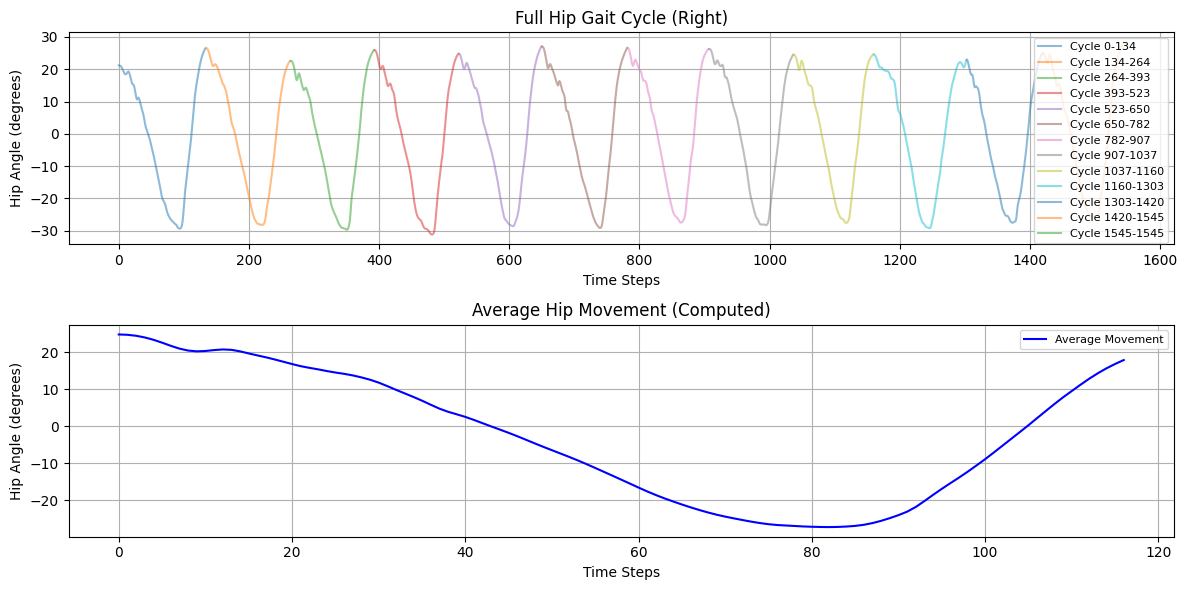

In [25]:
# Adjust start times to match the trimmed hip_angle
adjusted_hip_start_times = [start - hip_start_times[0] for start in hip_start_times]

# Compute the average movement for the hip gait cycle
average_hip_movement = compute_average_movement(hip_angle, adjusted_hip_start_times)

# Plot the full hip gait cycle and the average movement
plt.figure(figsize=(12, 6))

# Plot the full hip gait cycle
plt.subplot(2, 1, 1)
for start, end in zip(adjusted_hip_start_times, adjusted_hip_start_times[1:] + [len(hip_angle)]):
    plt.plot(np.arange(start, end), hip_angle[start:end], alpha=0.5, label=f"Cycle {start}-{end}")
plt.title("Full Hip Gait Cycle (Right)")
plt.xlabel("Time Steps")
plt.ylabel("Hip Angle (degrees)")
plt.legend(loc="upper right", fontsize=8)
plt.grid()

# Plot the average movement
plt.subplot(2, 1, 2)
plt.plot(average_hip_movement, color="blue", label="Average Movement")
plt.title("Average Hip Movement (Computed)")
plt.xlabel("Time Steps")
plt.ylabel("Hip Angle (degrees)")
plt.legend(loc="upper right", fontsize=8)
plt.grid()

plt.tight_layout()
plt.show()

___